# 1. Preprocessing of data

## 1.1 Configure the notebook and import libraries

Importing important libraries for data processing, visualisation, modelling and evaluation.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
import statsmodels
import forecast
from sklearn.metrics import mean_absolute_error as mae
import pmdarima as pm
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as st


In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## 1.2 Load the data and Initial EDA

Loading the data as `original_data`, setting `datetime` as index and performing initial EDA. It is important to note that the type of index is DateTimeIndex. Initial EDA includes initial glimpse of the data, converting the data into time series, checking for missing values etc.

The first 5 rows of the data suggest that the dataset is measured at an half-hourly interval, which means that the convertion to PeriodIndex need to be specified with a frequency of 30 minutes.

In [3]:
# load the data
original_data = pd.read_csv('solar_halfhour.csv', index_col='datetime', parse_dates=['datetime'], dayfirst=True)
original_data.head()

Customer  value
datetime                                  
2010-07-01 00:00:00+00:00         1  0.125
2010-07-01 00:30:00+00:00         1  0.303
2010-07-01 01:00:00+00:00         1  0.471
2010-07-01 01:30:00+00:00         1  0.083
2010-07-01 02:00:00+00:00         1  0.121

Converting the index from DateTimeIndex to PeriodIndex with a frequency of 30 minutes will ease the data processing and visualisation in the later stage.

In [4]:
# define time series as the value (energy production, measured in KWh)
y = original_data['value'].copy()
y.index = y.index.to_period(freq='30min')
ts = y
ts.tail()

datetime
2013-06-30 21:30    0.183
2013-06-30 22:00    0.134
2013-06-30 22:30    0.137
2013-06-30 23:00    0.140
2013-06-30 23:30    0.112
Freq: 30T, Name: value, dtype: float64

Missing values are checked and it is found that there are no missing values in the dataset. However, in case of missing, null, or invalid values at later stage when aggregation is performed, the `impute_missing_values(data)` function can be used to impute the missing values with the Last Observation Carried Forward (LOCF) method.

NOTE: summary statistics of the data is not shown here as the dataset still contains the test data, which should not be accessed by analytics following a parsimonious approach.

In [5]:
# missing or empty values for value
missing_value = original_data['value'].isnull().sum()
print('There are {} null values for value.'.format(missing_value))

# missing value for the whole dataset
missing_data = original_data.isnull().sum().sum()
print('There are {} null values for the whole dataset.'.format(missing_data))

# imputing missing values
def impute_missing_values(data):
    """ Last Observation Carried Forward (LOCF)"""
    if data.isnull().sum().sum() > 0:
        # fill missing values with last observation
        data = data.fillna(method='ffill')
    return data

There are 0 null values for value.
There are 0 null values for the whole dataset.


## 1.3 Aggregation of time series

The objective of this step is to aggregate the time series data to daily and monthly level as per the requirement of the project. Here, `resample('{freqstr}')` method is used to perform the aggregation. 

The output of the cell below contains a dataframe with half-hourly, daily and monthly aggregated data, as well as the dataframes for each customer with the aforementioned 3 different levels of aggregation. The reason for creating the dataframes is that these will facilitate the input parameter for later functions, as well as adding clarity to the analysis and code.

In [6]:
# All 3 datasets
# 1. 30min data
halfhour_data = original_data.copy()
# if data is not period, convert it to period
if not isinstance(halfhour_data.index, pd.PeriodIndex):
    halfhour_data.index = halfhour_data.index.to_period(freq='30min')

# Series of each customer
halfhour_C1 = halfhour_data[halfhour_data['Customer'] == 1]
halfhour_C2 = halfhour_data[halfhour_data['Customer'] == 2]
halfhour_C3 = halfhour_data[halfhour_data['Customer'] == 3]
halfhour_C4 = halfhour_data[halfhour_data['Customer'] == 4]

# 2. resample to daily data
ts_day = ts.resample('D').mean()
daily_data = original_data.groupby('Customer').resample('D').mean()
daily_data.index = daily_data.index.droplevel(0)
if not isinstance(daily_data.index, pd.PeriodIndex):
    daily_data.index = daily_data.index.to_period(freq='D')
# Series of each customer
daily_C1 = daily_data[daily_data['Customer'] == 1]
daily_C2 = daily_data[daily_data['Customer'] == 2]
daily_C3 = daily_data[daily_data['Customer'] == 3]
daily_C4 = daily_data[daily_data['Customer'] == 4]

# 3. resample to monthly data
ts_month = ts.resample('M').mean()
monthly_data = original_data.groupby('Customer').resample('M').mean()
monthly_data.index = monthly_data.index.droplevel(0)
if not isinstance(monthly_data.index, pd.PeriodIndex):
    monthly_data.index = monthly_data.index.to_period(freq='M')
# Series of each customer
monthly_C1 = monthly_data[monthly_data['Customer'] == 1]
monthly_C2 = monthly_data[monthly_data['Customer'] == 2]
monthly_C3 = monthly_data[monthly_data['Customer'] == 3]
monthly_C4 = monthly_data[monthly_data['Customer'] == 4]


## 1.4 Data Splitting into Train, Validation, and Test Sets

The objective of data splitting into train, validation and test set given a particular dataset (which can be any time series data e.g. original_data, daily_data, monthly_C1) is to ensure that the model is build upon the training set, where the expected outcome is found by examing the performance on the validation set. The test set is used to evaluate the actual performance of the model on unseen data (aka the predictive power of the model).

In [7]:
# Split the data into train and test set
# Reference: https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9
def split_train_test(data, test_size):

    """
        Given the dataset and the test size/forecast horizon,
        split the data into train, validation and test set.
    """
    # test set
    if test_size == 48: # imply half-hourly data
        test_set = data["value"].tail(48)
        # drop the test set from the original dataset
        data = data.iloc[:-48]
    elif test_size == 7: # imply daily data
        test_set = data["value"].tail(7)
        # drop the test set from the original dataset
        data = data.iloc[:-7]
    elif test_size == 1: # imply monthly data
        test_set = data["value"].tail(1)
        # drop the test set from the original dataset
        data = data.iloc[:-1]
    
    # initialise timeseriessplit with a split of 5, which is an arbitrary number
    tscv = TimeSeriesSplit(n_splits=5)

    X = data.drop(labels=['value'], axis=1)
    y = data['value']

    # train and validation set
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


    return X_train, X_val, y_train, y_val, test_set

# 2. Exploratory Data Analysis

The EDA here will be based upon customer1's data. An important underlying assumption is that customer1's behaviour is representative of the behaviour of all customers, in which the findings on trend and seasonality can be generalised to all customers. This means that the same set of models would be applied to all customers at the corresponding levels of aggregation.

## 2.1 Preparation for EDA
Set up the training set of customer 1 in terms of half-hourly, daily, and monthly data

In [8]:
# get the train, val, test set for customer 1
halfhour_X_train, halfhour_X_val, halfhour_ts_train, halfhour_ts_val, halfhour_test_set = split_train_test(halfhour_C1, test_size=48)
daily_X_train, daily_X_val, daily_ts_train, daily_ts_val, daily_test_set = split_train_test(daily_C1, test_size=7)
monthly_X_train, monthly_X_val, monthly_ts_train, monthly_ts_val, monthly_test_set = split_train_test(monthly_C1, test_size=1)

## 2.2 Plotting helper functions

Main functions for the initial detection of seasonality and trend in the data:

1. `plot_timeseries` produces the raw solar production level over time.

2. `plot_autocorrelation` produces the autocorrelation plot of the data, useful for detecting seasonality.

3. `plot_decomposition` produces the decomposition plot of the data, useful for detecting trend and residual.

Such auxiliary functions are useful since the repetitive plotting of the same type of graph can be avoided.

In [9]:
# plotting raw time series data
def plot_timeseries(ts):
    """
        Plot the time series to detect the trend and seasonality.
    """
    time_diff = ts.index[1] - ts.index[0]
    freq = None
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'): 
        freq = 'daily'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'monthly'

    fig, ax= plt.subplots(figsize=(8,5))
    ts.plot(color=blue)
    ax.set_xlabel('')
    ax.set_ylabel('Energy Production (kWh)')
    ax.set_title(f'Solar Power Production from household Solar Panels ({freq})')
    sns.despine()
    plt.show()

# ACF and PACF plots for the time series
def plot_autocorrelation(ts, lag):
    """
        Plot the autocorrelation and partial autocorrelation to detect the seasonality and model diagnostics.
    """
    fig, ax = plt.subplots(2,1,figsize=(8,5))
    sm.graphics.tsa.plot_acf(ts, lags=lag, ax=ax[0])
    plt.subplots_adjust(hspace=0.5)
    sm.graphics.tsa.plot_pacf(ts, lags=lag, ax=ax[1])
    sns.despine()
    plt.show()

# Decomposition of the time series
def plot_decomposition(ts, period):
    """ 
        Decompose the time series into trend, seasonality and residuals.
    """
    ts_dec = ts.copy()
    ts_dec.index = ts_dec.index.to_timestamp()
    # # log transform the data to stabilise the variance, which will benefit the decomposition process as if the seasonal change is constant, it would be beneficial to decompose the time series
    ts_dec = np.log(ts_dec)
    if period == '30min':
        decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts_dec[-1400:], period = 48)
    elif period == 'daily':
        decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts_dec[-200:], period = 9)
    elif period == 'monthly':
        decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts_dec[-24:], period = 5)
    decomposition.plot()
    plt.show()

## 2.3 Visualise the half-hourly data

Given 43800 observations in the half-hourly training set, a full plot as well as a subset of the data is shown below. Findings are in section 2.3.1.

In [10]:
halfhour_ts_train.describe()

count    43800.000000
mean         0.320068
std          0.309545
min          0.000000
25%          0.111000
50%          0.197000
75%          0.424000
max          2.680000
Name: value, dtype: float64

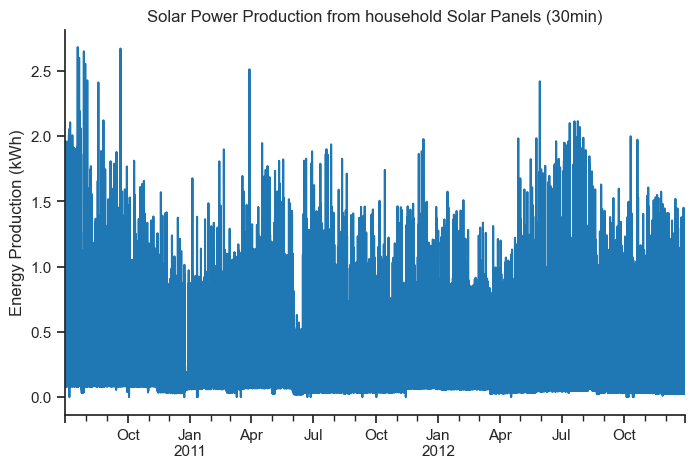

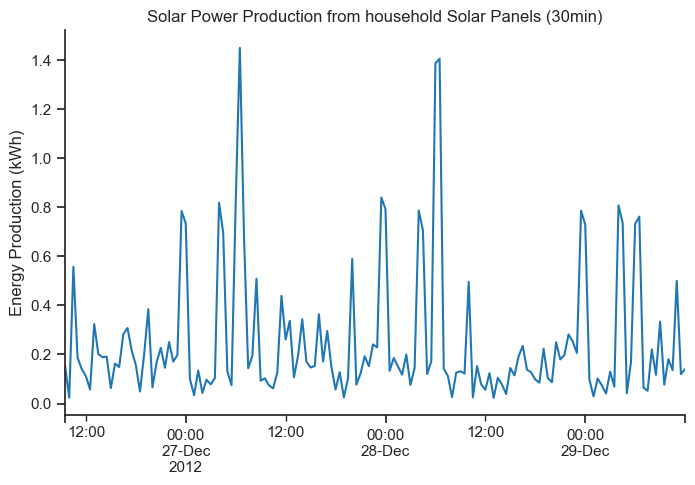

In [11]:
# plot the time series
plot_timeseries(halfhour_ts_train)

# reduce frequency for better detection of trend and seasonality
plot_timeseries(halfhour_ts_train[-150:])


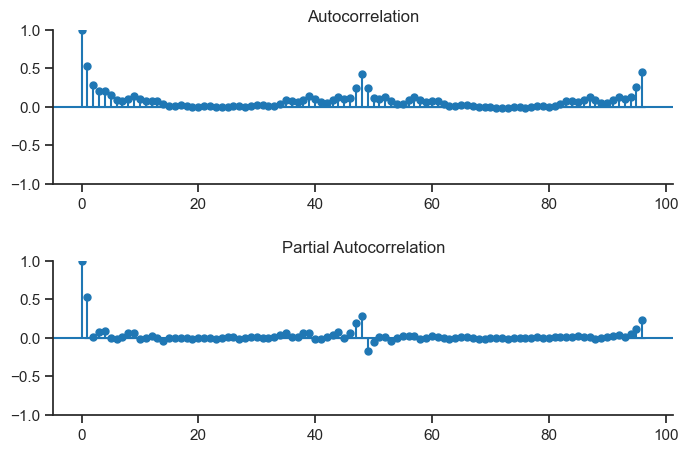

In [12]:
# further detection of seasonality using autocorrelation and partial autocorrelation
plot_autocorrelation(halfhour_ts_train, 96)

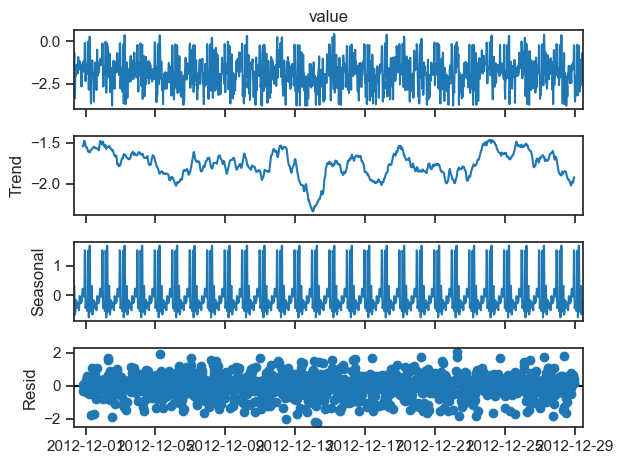

In [13]:
# decompose the time series into trend, seasonality and residuals
plot_decomposition(halfhour_ts_train, '30min')
plt.rcParams['figure.figsize'] = [15, 8]

## 2.3.1 Findings for half-hourly data
1. Trend: There is no clear trend for both the full training data and the subset of training data. The decomposition plot also reafirms the finding that there is no trend in the data.

2. Seasonality: Pattern is not clear for the full training data due to the high frequency of data. However, there is a seasonality pattern for the subset of training data, where the solar power production seems to peak at around early noon. The finding is intuitive as the solar power is expected to be the strongest in the middle of the day. Therefore, period is expected to be 24 hours, or 48 half-hourly periods.

3. Period for seasonality: from the autocorrelation plot of lag 96, it is evident that the same pattern repeats roughly every 48 half-hourly periods. This is consistent with the finding in 2.3.1.

4. Magnitude of seasonality: The subset of training data reveals that the magnitude of seasonal change is almost constant throughout each period / day. For instance, the kWh peaked at 27-Dec-2012 is very similar to the level of kWh peaked at 28-Dec-2012.

5. Recommended model: Based on aforementioned findings (i.e. no trend, seasonality with period 48 half hourly periods, and seasonal change is mostly constant), the recommended models to perform for model selection are:
    - Random walk (baseline model)
    - Seasonal random walk (since strong seasonality is observed)
    - Holt-Winter's exponential smoothing with additive seasonality (Although no clear trend is observed, it is still worth trying out the additive trend model to see if it can improve the performance of the model.)
    - ARIMA (flexible model)

6. The reason that exponential holt, simple exponential smoothing, and multiplicative holt winter are not included is because holt is suitable for time series without seasonality and multiplicative holt winter is suitable for time series with inconsistent seasonal change. Simple exponential smoothing is suitable for time series without trend and seasonality, which is not the case here.

## 2.4 Visualise the daily data

Same set of plots are produced for the daily data. Findings are in section 2.4.1.

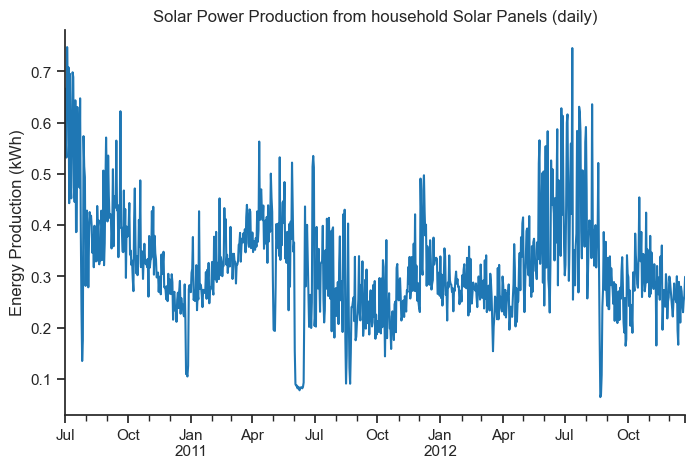

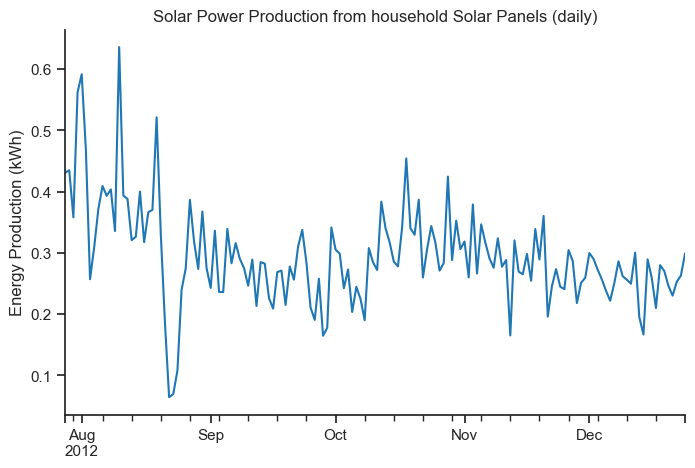

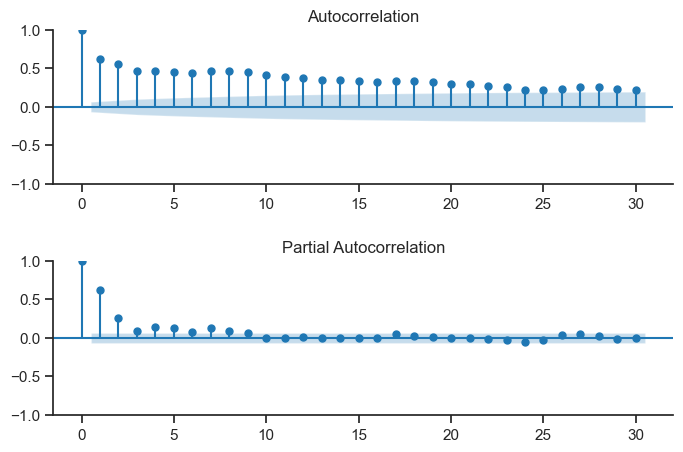

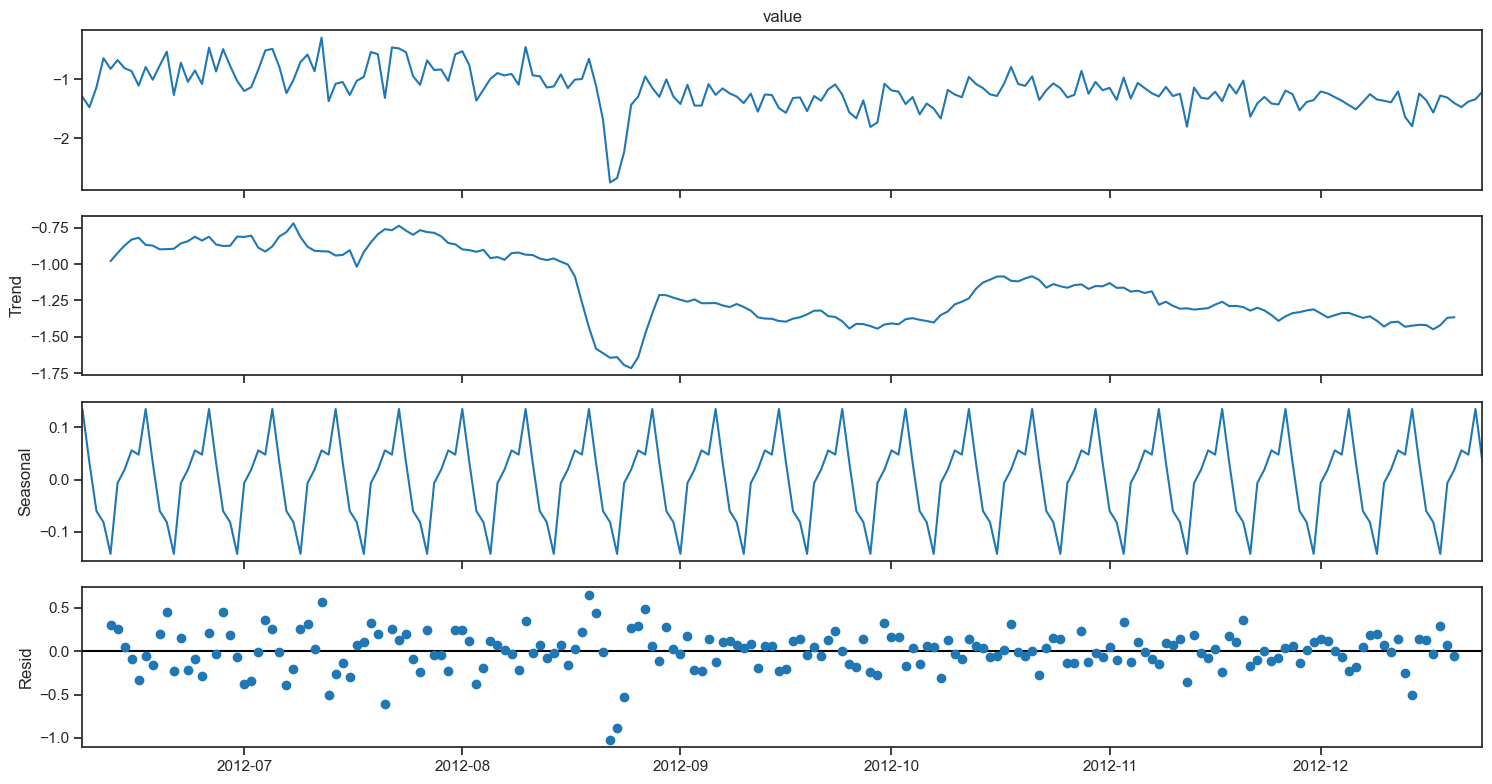

In [14]:
plot_timeseries(daily_ts_train)
plot_timeseries(daily_ts_train[-150:])

# further detection of seasonality using autocorrelation and partial autocorrelation
plot_autocorrelation(daily_ts_train, 30)

# decompose the time series into trend, seasonality and residuals
plot_decomposition(daily_ts_train, 'daily')

### 2.4.1 Findings for daily data
1. Trend: There is slight decreasing trend for both the full training data and the subset of training data, where the subset exert more prominent decreasing trend relatively. The decomposition plot also reafirms such finding.

2. Seasonality: A gist of seasonality pattern can be observed for the full training data, where the time frame for the repeated pattern varied from 6month to 10 month, which is not meaningful considering the nature of the frequency being measured daily. Looking on a smaller scale, the ACF and PACF was performed with a lag of 30 days. Nevertheless, no strong pattern can be observed except for a minor spike every 9 days (from eyeballing). The reason for strong seasonality in the decomposition plot is because the decomposition function is configured to have a period of 9 days, which is not indicative of the real seasonality pattern of the data.

3. Recommended model: Based on aforementioned findings (i.e. slight decreasing trend, no clear seasonality), the recommended models to perform for model selection are:
    - Random walk (baseline model)
    - Damped holt exponential smoothing (since the model is suitable for time series with decreasing trend and no seasonality)
    - ARIMA (flexible model)

## 2.5 Visualise the monthly data

Same set of plots are produced for the monthly data. Findings are in section 2.5.1.

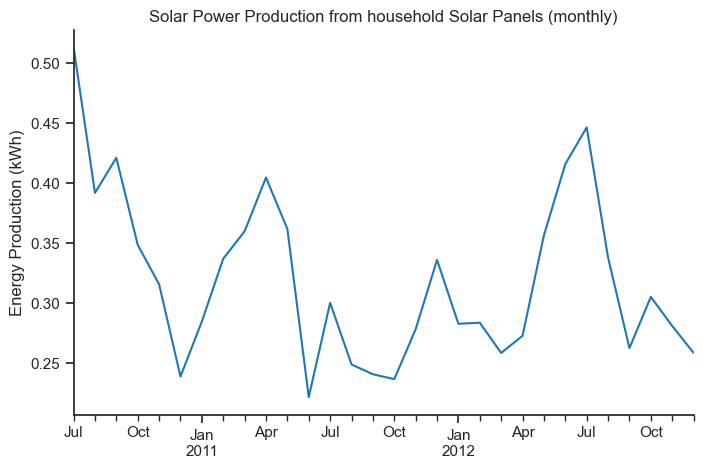

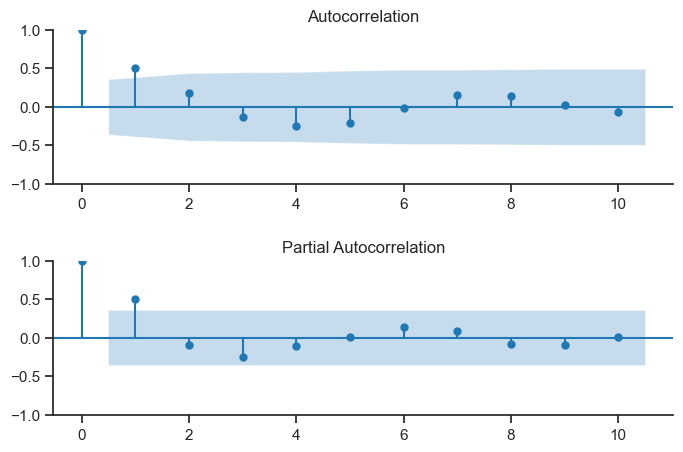

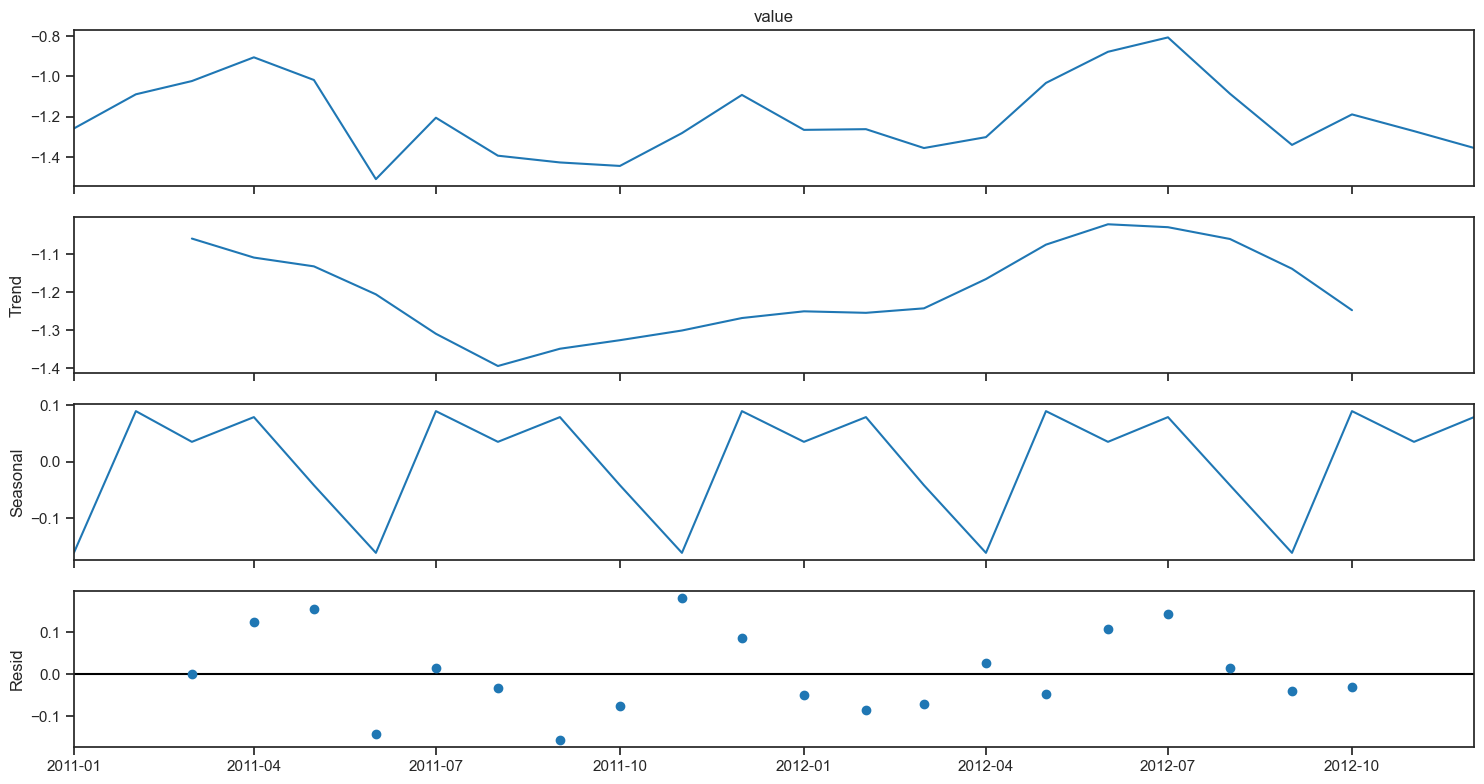

In [15]:
# plot the time series 
plot_timeseries(monthly_ts_train)

# further detection of seasonality using autocorrelation and partial autocorrelation
plot_autocorrelation(monthly_ts_train, 10)

# decompose the time series into trend, seasonality and residuals
plot_decomposition(monthly_ts_train, 'monthly')

### 2.5.1 Findings for monthly data
1. Trend: no clear trend is evident from the full training set nor the decomposed training set.

2. Seasonality: according to the ACF and PACF plot, there is a strong seasonality pattern with a period of 5 months. The magnitude of seasonal change is varied as seen in the time series plot for the full training data.

3. Recommended model: Based on aforementioned findings (i.e. no clear trend, strong seasonality), the recommended models to perform for model selection are:
    - Random walk (baseline model)
    - Seasonal random walk (since strong seasonality is observed)
    - Holt-Winter's exponential smoothing with multiplicative seasonality
    - ARIMA (flexible model)

# 3. Model Selection and Forecast Results

This section contains:
1. Helper functions for model selection

2. Model selection for half-hourly data (manual and automated methodolgy) & forecast results for half-hourly data

3. Model selection for daily data (automated methodolgy) & forecast results for daily data

4. Model selection for monthly data (automated methodolgy) & forecast results for monthly data


## 3.1 Helper functions

### 3.1.1 Point forecasting helper functions

Based on EDA, generalised functions for point forecasting are created for the following models:
1. Random walk
2. Seasonal random walk
3. Holt-Winter's exponential smoothing with additive seasonality
4. Holt-Winter's exponential smoothing with multiplicative seasonality
5. Damped holt exponential smoothing
6. ARIMA

In [16]:
# random walk
def random_walk_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and the forecast horizon, 
        return the point forecast using the random walk method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    if time_diff == pd.Timedelta('30 min'):
        # random walk
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='30min')
        pred = pd.Series(np.repeat(ts_train.iloc[-1], h), index=test)
        # expected performance: MAE on validation set
        exp_mae = mae(ts_val, pd.Series(np.repeat(ts_train.iloc[-1], len(ts_val)), index=ts_val.index))
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    elif time_diff == pd.Timedelta('1 day'):
        # random walk
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='D')
        pred = pd.Series(np.repeat(ts_train.iloc[-1], h), index=test)
        # expected performance: MAE on validation set
        exp_mae = mae(ts_val, pd.Series(np.repeat(ts_train.iloc[-1], len(ts_val)), index=ts_val.index))
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    elif time_diff == pd.tseries.offsets.MonthEnd():
        # random walk
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='M')
        pred = pd.Series(np.repeat(ts_train.iloc[-1], h), index=test)
        # expected performance: MAE on validation set
        exp_mae = mae(ts_val, pd.Series(np.repeat(ts_train.iloc[-1], len(ts_val)), index=ts_val.index))
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    return pred, exp_mae, act_mae

# seasonal random walk
def seasonal_random_walk_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and the forecast horizon, 
        return the point forecast using the seasonal random walk method.
        Note: only works for half-hourly and monthly data where seasonality is detected with period of 48 and 5 respectively.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    pred = []
    if time_diff == pd.Timedelta('30 min'):
        for i in range(h):
            pred.append(ts_train.iloc[-48+i])
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='30min')
        pred = pd.Series(pred, index=test)
        # expected performance: MAE on validation set
        pred_val = []
        for i in range(len(ts_val)):
            pred_val.append(ts_train.iloc[-48+i])
        pred_val = pd.Series(pred_val, index=ts_val.index)
        exp_mae = mae(ts_val, pred_val)
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    elif time_diff == pd.tseries.offsets.MonthEnd():
        for i in range(h):
            pred.append(ts_train.iloc[-5+i])
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='M')
        pred = pd.Series(pred, index=test)
        # expected performance: MAE on validation set
        pred_val = []
        for i in range(len(ts_val)):
            pred_val.append(ts_train.iloc[-5+i])
        pred_val = pd.Series(pred_val, index=ts_val.index)
        exp_mae = mae(ts_val, pred_val)
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    return pred, exp_mae, act_mae

# # holt damped
def holt_damped_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and the forecast horizon, 
        return the point forecast using the Holt method.
        Note: only works for daily data in the presence of trend and absence of seasonality.
    """
    holt = forecast.holt(ts_train, damped=True)
    holt.fit()
    smoothed = pd.Series(holt.smooth(), index=ts_train.index)
    fig, ax= plt.subplots(figsize=(10,6))
    ts_train.plot(color='#D62728', label='trend-corrected energy production')
    smoothed.plot(color='black', label='Smoothed', alpha=0.65)
    plt.legend(loc='best')
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='D')
    pred_holt_daily = pd.Series(holt.forecast(h), index=test)
    # expected performance: MAE on validation set
    exp_mae_holt_daily = mae(ts_val, pd.Series(holt.forecast(len(ts_val)), index=ts_val.index))
    
    # actual performance: MAE on test set
    act_mae = mae(ts_test, pred_holt_daily)

    return pred_holt_daily, exp_mae_holt_daily, act_mae


# holt winter additive
def holt_winters_additive_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and forecast horizon
        return the point forecast using the Holt-Winters Additive method.
        Note1: only works for half-hourly data where seasonality is detected with period of 48.
        Note2: due to the high frequency of the data, the plot output the last few data points of the training set and the forecast.
    """
    pred = []    
    holt = forecast.holtwinters(ts_train, m=h)
    holt.fit()
    time_diff = ts_train.index[1] - ts_train.index[0]
    if time_diff == pd.Timedelta('30 min'):
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='30min')
        pred = pd.Series(holt.forecast(h), index=test)
        # expected performance: MAE on validation set
        exp_mae = mae(ts_val, pd.Series(holt.forecast(len(ts_val)), index=ts_val.index))
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    return pred, exp_mae, act_mae

# holt winter multiplicative
def holt_winters_multiplicative_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and forecast horizon
        return the point forecast using the Holt-Winters Additive method.
        Note1: only works for half-hourly data where seasonality is detected with period of 48.
        Note2: due to the high frequency of the data, the plot output the last few data points of the training set and the forecast.
    """
    pred = []    
    holt = forecast.holtwinters(ts_train, m=h, additive=False)
    holt.fit()
    time_diff = ts_train.index[1] - ts_train.index[0]
    if time_diff == pd.tseries.offsets.MonthEnd():
        test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq='M')
        pred = pd.Series(holt.forecast(h), index=test)
        # expected performance: MAE on validation set
        exp_mae = mae(ts_val, pd.Series(holt.forecast(len(ts_val)), index=ts_val.index))
        # actual performance: MAE on test set
        act_mae = mae(ts_test, pred)

    return pred, exp_mae, act_mae

# ARIMA aic
def ARIMA_aic_point_forecast(ts_train, ts_val, ts_test, h):
    """
        Given the time series and the forecast horizon, 
        return the point forecast using the ARIMA model.
    """
    order = st.arma_order_select_ic(ts_train, ic=['aic'], max_ar=3, max_ma=3)
    p,q = order.aic_min_order
    arima_AIC = sm.tsa.arima.ARIMA(ts_train, order=(p,1,q)).fit()
    # expected performance: MAE on validation set
    exp_mae_AIC = mae(ts_val, arima_AIC.forecast(steps=len(ts_val)))
    
    # actual performance: MAE on test set
    act_mae = mae(ts_test, arima_AIC.forecast(steps=h))
    pred = arima_AIC.forecast(steps=h, index=ts_test.index)

    return pred, exp_mae_AIC, act_mae


### 3.1.2 Interval forecasting helper functions

Same sets of model but with interval forecasting are created. Note that the interval has a confidence level of 95%.

In [17]:
# interval forecast
## random walk interval forecast
def random_walk_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the random walk method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'
    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = random_walk_point_forecast(ts_train, ts_val, ts_test, h)[0]
    resid = ts_train - ts_train.shift(1)
    sigma = np.std(resid)

    # 95% confidence interval
    intv_ts = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)), 
                         pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)
    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh Random Walk forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()


## seasonal random walk interval forecast
def seasonal_random_walk_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the random walk method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'
    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = seasonal_random_walk_point_forecast(ts_train, ts_val, ts_test, h)[0]
    resid = ts_train - ts_train.shift(1)
    sigma = np.std(resid)

    # 95% confidence interval
    intv_ts = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)), 
                         pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)
    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh Seasonal Random Walk forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

# holt winter additive interval forecast
def holt_winter_add_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the Holt-Winters Additive method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'

    holt = forecast.holtwinters(ts_train, additive=True)
    holt.fit()
    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = pd.Series(holt.forecast(h), index=test)

    # 95% confidence interval
    intv_ts = pd.DataFrame(holt.intervalforecast(h, level=.95), index=test)
    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)

    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh Holt-Winters Additive forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

# arima interval forecast
def ARIMA_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the arima method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'

    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = ARIMA_aic_point_forecast(ts_train, ts_val, ts_test, h)[0]
    std_err = ARIMA_aic_point_forecast(ts_train, ts_val, ts_test, h)[1]
    # 95% confidence interval
    lower_bound = pred - 1.96 * std_err
    upper_bound = pred + 1.96 * std_err
    intv_ts = pd.concat([lower_bound, upper_bound], axis=1)

    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)

    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh ARIMA forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()


def holt_winter_mul_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the Holt-Winters Additive method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'

    holt = forecast.holtwinters(ts_train, additive=False)
    holt.fit()
    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = pd.Series(holt.forecast(h), index=test)

    # 95% confidence interval
    intv_ts = pd.DataFrame(holt.intervalforecast(h, level=.95), index=test)
    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)

    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh Holt-Winters Multiplicative forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

# holt damped interval forecast
def holt_damp_interval_forecast(ts_train, ts_val, ts_test, h):
    """ 
        Given the time series and forecast horizon
        return the interval forecast using the Holt Damped method.
    """
    time_diff = ts_train.index[1] - ts_train.index[0]
    freq = None
    # determine the frequency
    if time_diff == pd.Timedelta('30 min'):
        freq = '30min'
    elif time_diff == pd.Timedelta('1 day'):
        freq = 'D'
    elif time_diff == pd.tseries.offsets.MonthEnd():
        freq = 'M'

    holt = forecast.holt(ts_train, damped=True)
    holt.fit()
    test = pd.period_range(start=ts_val.index[-1]+1, periods=h, freq=freq)
    pred = pd.Series(holt.forecast(h), index=test)

    # 95% confidence interval
    intv_ts = pd.DataFrame(holt.intervalforecast(h, level=.95), index=test)
    # fan chart
    intv_redundant1 = pd.DataFrame(np.zeros((h,2)), index=test)
    intv_redundant2 = pd.DataFrame(np.zeros((h,2)), index=test)
    train_val = pd.concat([ts_train, ts_val], axis=0)

    fig1, ax1 = forecast.fanchart(train_val[-150:], pred, intv_ts, intv_redundant1, intv_redundant2)
    ax1.set_xlabel('')
    ax1.set_ylabel('Energy Production (kWh)')
    plt.title('Half Hourly KWh Holt Damped forecast', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

### 3.1.2 Helper functions for model evaluation

Provide a simple way to visualise the performance of the model in terms of point forecasting vs the true (test) value.

In [18]:
def plot_forecast_actual(ts_test, ts_pred):
    """
        Plot the actual and forecasted time series to visualise performance
    """
    test_forplot = ts_test.copy().to_frame()
    test_forplot.columns = ['actual']
    test_forplot['pred'] = ts_pred
    test_forplot.plot()

## 3.2 Half-hourly forecasting

Based on EDA, the 4 models to be tested are:

1. Random walk (baseline model)
2. Seasonal random walk (since strong seasonality is observed)
3. Holt-Winter's exponential smoothing with additive seasonality (Although no clear trend is observed, it is still worth trying out the additive trend model to see if it can improve the performance of the model.)
4. ARIMA (flexible model)

### 3.2.1 Point Forecasting for customer 1 (manual methodology)

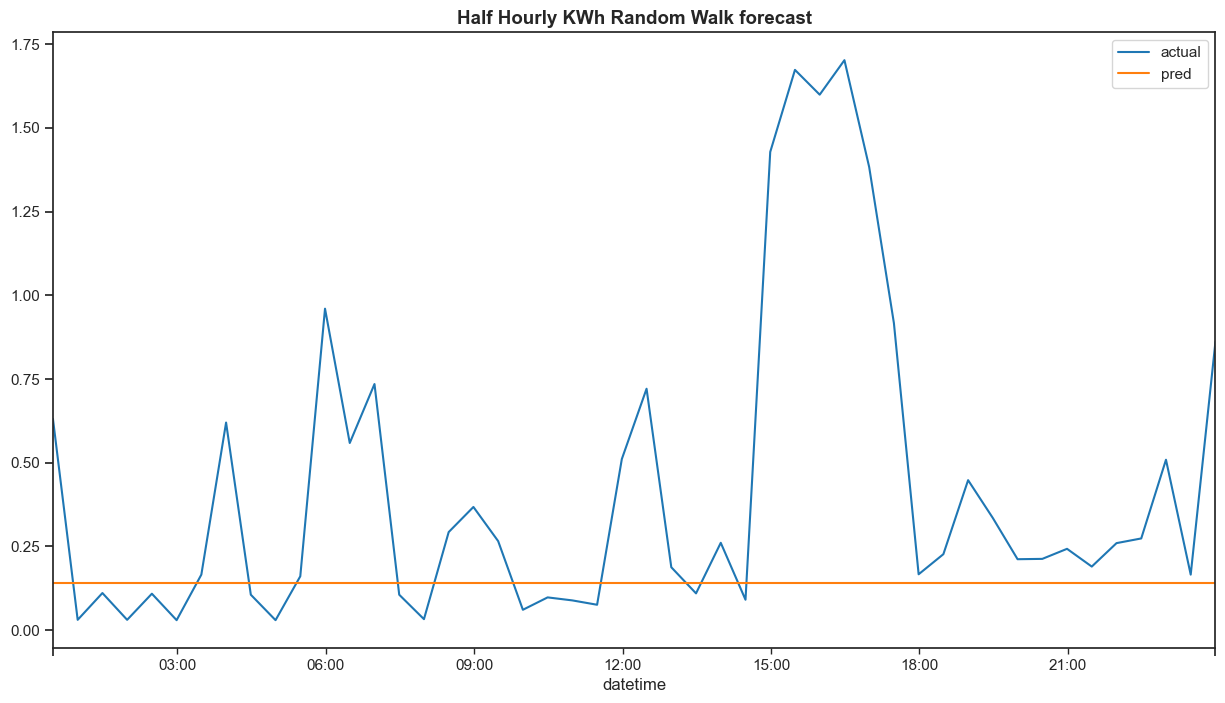

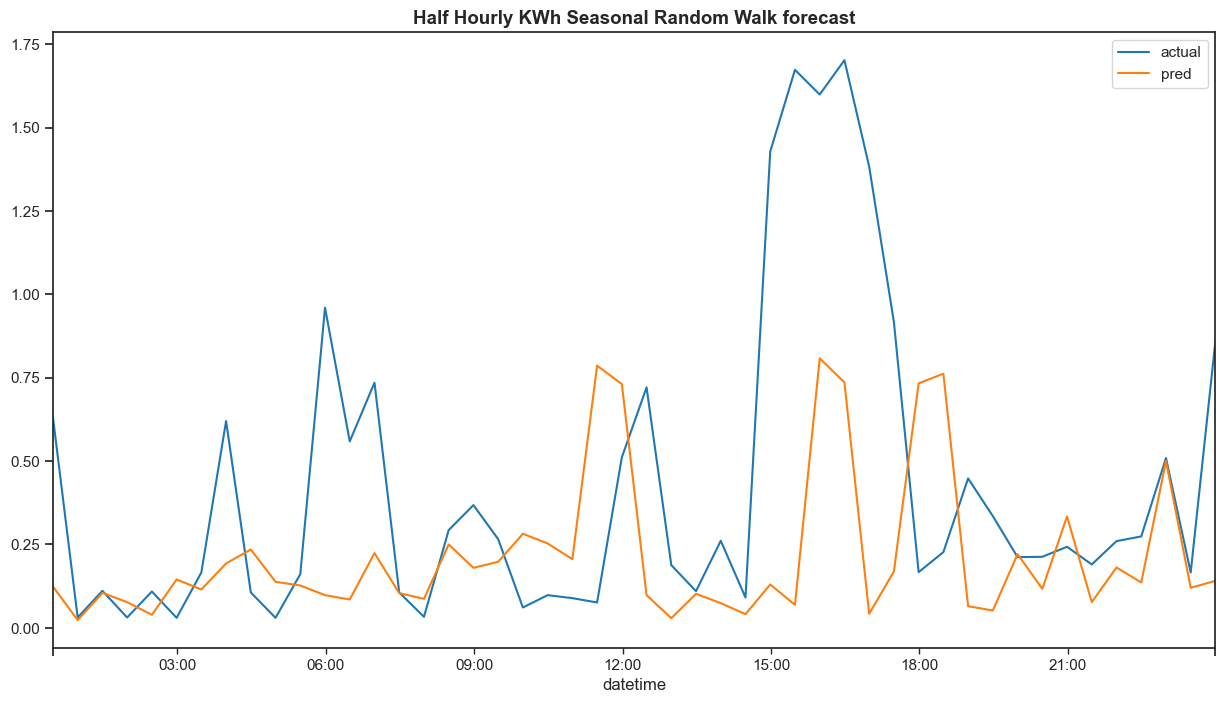

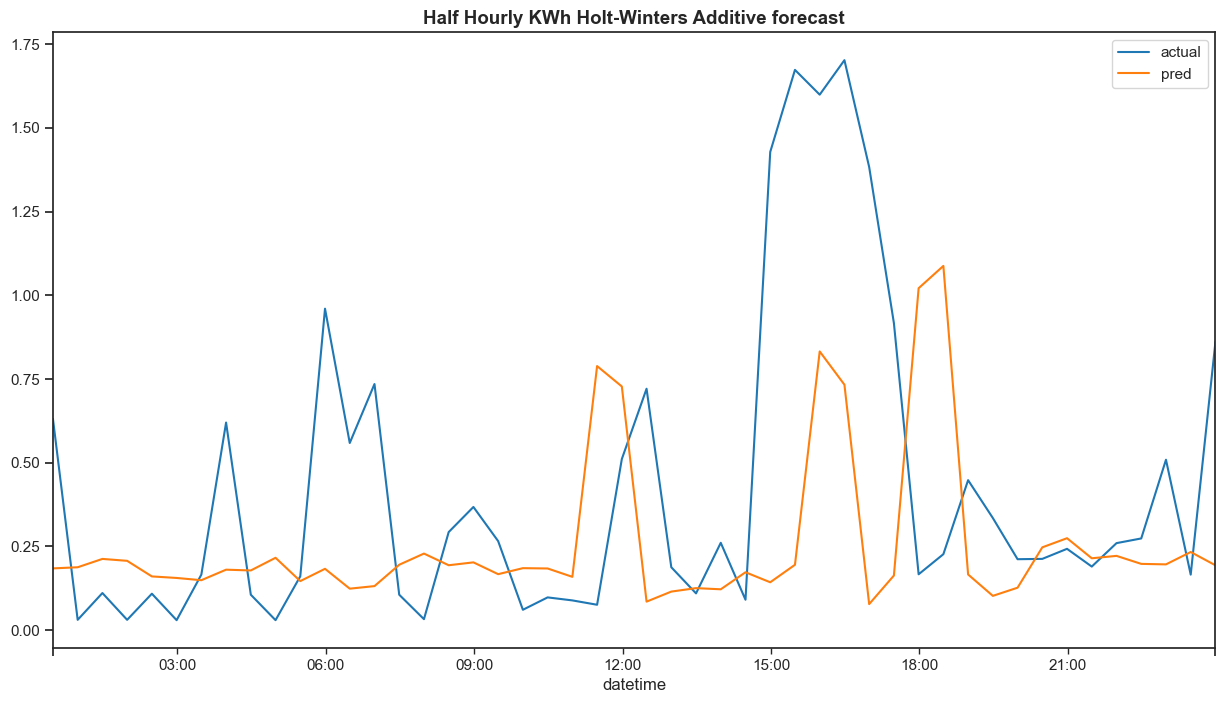

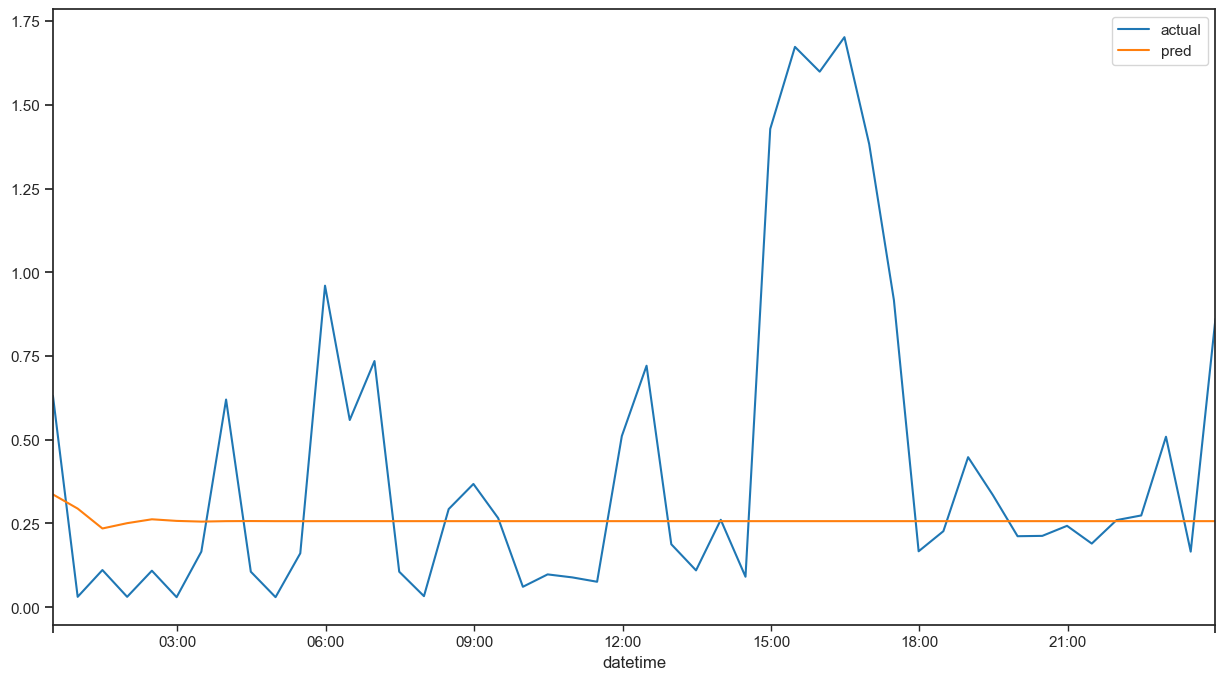

In [19]:
# Point forecast next 48 half-hourly data
## random walk
pred_rw_half_hour, exp_mae_rw_half_hour, act_mae_rw_half_hour = random_walk_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
plot_forecast_actual(halfhour_test_set, pred_rw_half_hour)
plt.title('Half Hourly KWh Random Walk forecast', fontsize=13.5, fontweight='bold')

## seasonal random walk
pred_srw_half_hour, exp_mae_srw_half_hour, act_mae_srw_half_hour = seasonal_random_walk_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
plot_forecast_actual(halfhour_test_set, pred_srw_half_hour)
plt.title('Half Hourly KWh Seasonal Random Walk forecast', fontsize=13.5, fontweight='bold')

## Holt-Winters Additive
pred_holt_add_half_hour, exp_mae_holt_add_half_hour, act_mae_holt_add_half_hour = holt_winters_additive_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
plot_forecast_actual(halfhour_test_set, pred_holt_add_half_hour)
plt.title('Half Hourly KWh Holt-Winters Additive forecast', fontsize=13.5, fontweight='bold')

# ARIMA
pred_arima_half_hour, exp_mae_arima_half_hour, act_mae_arima_half_hour = ARIMA_aic_point_forecast(halfhour_ts_train[-1500:], halfhour_ts_val[-1500:], halfhour_test_set, 48)
plot_forecast_actual(halfhour_test_set, pred_arima_half_hour)

### 3.2.2 Model Performance (Point Forecasting)

The table below shows that Holt-Winter Additive forecasting model is the best model based on the expected MAE.

In [20]:
# summarising the model performance in terms of MAE
columns = ['Model', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference', 'Forecast']
half_hourly_results = pd.DataFrame(columns=columns)
half_hourly_results.loc[0] = ['Random Walk', exp_mae_rw_half_hour, act_mae_rw_half_hour, abs(exp_mae_rw_half_hour-act_mae_rw_half_hour), pred_rw_half_hour]
half_hourly_results.loc[1] = ['Seasonal Random Walk', exp_mae_srw_half_hour, act_mae_srw_half_hour, abs(exp_mae_srw_half_hour-act_mae_srw_half_hour), pred_srw_half_hour]
half_hourly_results.loc[2] = ['Holt-Winters Additive', exp_mae_holt_add_half_hour, act_mae_holt_add_half_hour, abs(exp_mae_holt_add_half_hour-act_mae_holt_add_half_hour), pred_holt_add_half_hour]
half_hourly_results.loc[3] = ['ARIMA', exp_mae_arima_half_hour, act_mae_arima_half_hour, abs(exp_mae_arima_half_hour-act_mae_arima_half_hour), pred_arima_half_hour]
half_hourly_results.round(4)


Model  Expected Performance(MAE)  Actual Performance(MAE)  \
0            Random Walk                     0.1897                   0.3249   
1   Seasonal Random Walk                     0.3214                   0.3327   
2  Holt-Winters Additive                     0.1520                   0.3444   
3                  ARIMA                     0.2451                   0.3066   

   Difference                                           Forecast  
0      0.1352  2013-06-30 00:00    0.141
2013-06-30 00:30    ...  
1      0.0113  2013-06-30 00:00    0.124
2013-06-30 00:30    ...  
2      0.1924  2013-06-30 00:00    0.184593
2013-06-30 00:30 ...  
3      0.0615  datetime
2013-06-30 00:00    0.336756
2013-06-...

### 3.2.3 Model Selection (Point Forecasting)


- Random walk and seasonal random walk are the most naive models, which serves as the baseline model for comparison. Examining the expected performance, holt-winter's exponential smoothing with additive seasonality is performing the best, however, ARIMA model is performing worse than the baseline model. This is due to the trade-off between accuracy and time complexity from my decision (see below)

- Although auto-arima theoretically should provide a lower error, however, considering the time complexity of over 20 minutes, it is not feasible to use auto-arima for model selection. Meanwhile, eyeballing the ACF and PACF plot is not a reliable nor objective method to select the best model. Considering the trade-off between accuracy and time complexity, the approach of choosing the order of ARIMA model based on the lowest AIC is adopted.

- Final model selection is based on 3 criterias, ordered by priority:
    1. lowest MAE on validation set (since validation set is a large set of data, containing 8760 half-hourly periods, also a low MAE on validation set is indicative of an overall less overfitting model to the training set, thus more generalisable to the test set)

    2. lowest absolute difference between the expected MAE and the actual MAE. This is because a small difference implies that the model is performing as expected, and the model is not overfitting to a particular set of data.

    3. lowest MAE on test set would still crucial in terms of the predictive power of the model. However, it is not of the highest priority since the test set is relatively small, consisting only 48 half-hourly periods, and the test set is generally not accessible in real life.

- Based on the aforementioned criterias, the best model is the Holt-Winter's exponential smoothing with additive seasonality model. It has the lowest MAE on validation set being 0.1520, with an absolute difference of 0.015 between the expected and actual performance. Last but not least, its actual performance is not the worst, with a MAE of 0.1365 on the test set.

- However, it is important to note that model that perform worst on validation set (i.e. ARIMA) actually perform significantly better on the test set. Therefore, for future work, it is recommended to perform model selection based on a larger test set, or to perform cross validation to examine the generalisability of the model.

In [21]:
# final model selection (minimum expected MAE on validation set, if same, choose the one with smaller difference, then choose the one with smaller actual MAE on test set)
half_hourly_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)
final_model = half_hourly_results.iloc[0,0]
final_forecast = half_hourly_results.iloc[0,4]

# drop the last column
half_hourly_results.drop(columns=['Forecast'], inplace=True)
half_hourly_results

Model  Expected Performance(MAE)  Actual Performance(MAE)  \
2  Holt-Winters Additive                   0.151996                 0.344360   
0            Random Walk                   0.189699                 0.324938   
3                  ARIMA                   0.245142                 0.306623   
1   Seasonal Random Walk                   0.321408                 0.332688   

   Difference  
2    0.192364  
0    0.135238  
3    0.061481  
1    0.011280

The final model and its forecast results are shown below.

In [22]:
print(
    f'The final model selected for half-hourly data is {final_model}.' + '\n' +
    f'The expected performance on validation set is {half_hourly_results.iloc[0,1]}.' + '\n' +
    f'The actual performance on test set is {half_hourly_results.iloc[0,2]}.' + '\n' +
    f'The difference between expected and actual performance is {half_hourly_results.iloc[0,3]}.' + '\n'
    f'The point forecast for the next 48 half-hourly data is as follows: \n' +
    "======================================================================================================" + '\n' +
    f'{final_model} \n' +
    f'{final_forecast} \n' +
    "======================================================================================================"
)

The final model selected for half-hourly data is Holt-Winters Additive.
The expected performance on validation set is 0.1519958842396979.
The actual performance on test set is 0.34435993700017137.
The difference between expected and actual performance is 0.19236405276047347.
The point forecast for the next 48 half-hourly data is as follows: 
Holt-Winters Additive 
2013-06-30 00:00    0.184593
2013-06-30 00:30    0.187950
2013-06-30 01:00    0.212874
2013-06-30 01:30    0.207169
2013-06-30 02:00    0.160599
2013-06-30 02:30    0.156019
2013-06-30 03:00    0.149311
2013-06-30 03:30    0.180731
2013-06-30 04:00    0.178426
2013-06-30 04:30    0.216243
2013-06-30 05:00    0.146643
2013-06-30 05:30    0.183338
2013-06-30 06:00    0.124058
2013-06-30 06:30    0.131708
2013-06-30 07:00    0.195457
2013-06-30 07:30    0.228842
2013-06-30 08:00    0.193998
2013-06-30 08:30    0.202573
2013-06-30 09:00    0.167317
2013-06-30 09:30    0.185284
2013-06-30 10:00    0.184308
2013-06-30 10:30    0.15

### 3.2.5 Interval Forecasting
1. Random walk (baseline model)
2. Seasonal random walk (since strong seasonality is observed)
3. Holt-Winter's exponential smoothing with additive seasonality (Although no clear trend is observed, it is still worth trying out the additive trend model to see if it can improve the performance of the model.)
4. ARIMA (flexible model)

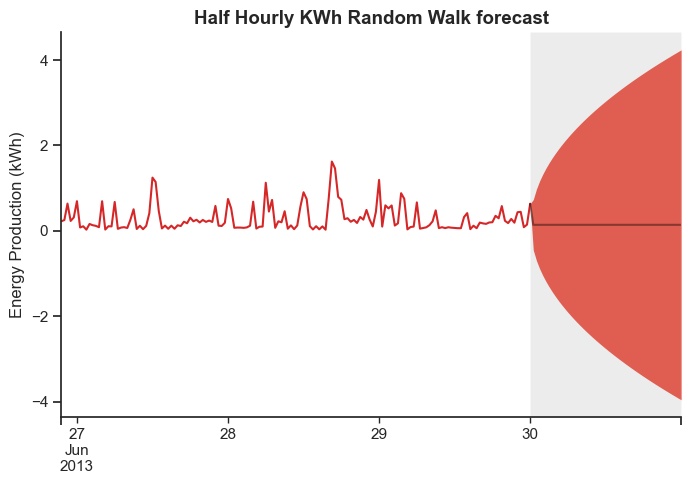

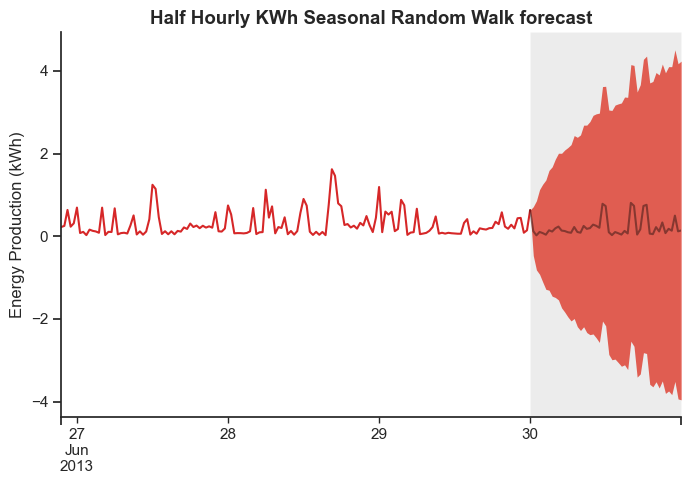

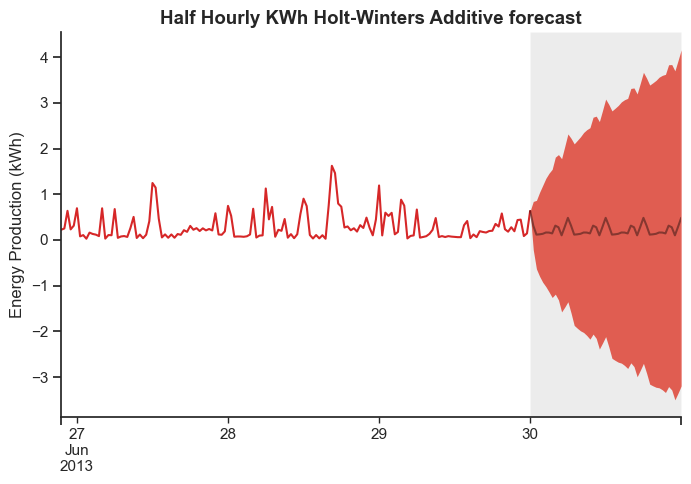

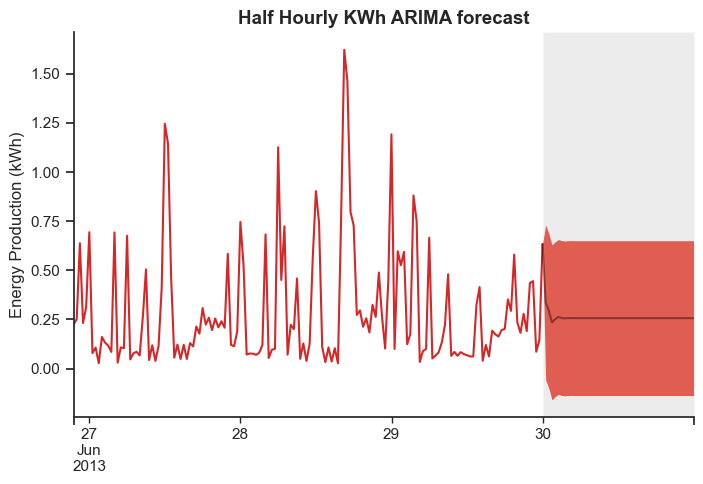

In [23]:
# random walk
random_walk_interval_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
# seasonal random walk
seasonal_random_walk_interval_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
# holt winter additive
holt_winter_add_interval_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
# arima
ARIMA_interval_forecast(halfhour_ts_train[-1500:], halfhour_ts_val, halfhour_test_set, 48)

### 3.2.6 Automatic methodological approach for half-hourly data


In [24]:
# helper function for final model selection
def half_hourly_point_forecast_model_selection(half_hourly_ts):
    """ 
        Given the time series for a particular customer and the metric for evaluating the model performance,
        return the best model, final forecast, expected performance and actual performance.
    """
    # Step 1: split the data into train, validation and test set
    halfhour_X_train, halfhour_X_val, halfhour_ts_train, halfhour_ts_val, halfhour_test_set = split_train_test(half_hourly_ts, test_size=48)

    # Step 2: point forecast using random walk
    pred_rw_half_hour, exp_mae_rw_half_hour, act_mae_rw_half_hour = random_walk_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
    # Step 2.1: plot the forecast against the actual
    plot_forecast_actual(halfhour_test_set, pred_rw_half_hour)
    plt.title('Half Hourly KWh Random Walk forecast', fontsize=13.5, fontweight='bold')

    # Step 3: point forecast using seasonal random walk
    pred_srw_half_hour, exp_mae_srw_half_hour, act_mae_srw_half_hour = seasonal_random_walk_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
    # Step 3.1: plot the forecast against the actual
    plot_forecast_actual(halfhour_test_set, pred_srw_half_hour)
    plt.title('Half Hourly KWh Seasonal Random Walk forecast', fontsize=13.5, fontweight='bold')

    # Step 4: point forecast using Holt-Winters Additive
    pred_holt_add_half_hour, exp_mae_holt_add_half_hour, act_mae_holt_add_half_hour = holt_winters_additive_point_forecast(halfhour_ts_train, halfhour_ts_val, halfhour_test_set, 48)
    # Step 4.1: plot the forecast against the actual
    plot_forecast_actual(halfhour_test_set, pred_holt_add_half_hour)
    plt.title('Half Hourly KWh Holt-Winters Additive forecast', fontsize=13.5, fontweight='bold')
    
    # Step 5: point forecast using ARIMA
    pred_arima_half_hour, exp_mae_arima_half_hour, act_mae_arima_half_hour = ARIMA_aic_point_forecast(halfhour_ts_train[-1500:], halfhour_ts_val[-1500:], halfhour_test_set, 48)
    # Step 5.1: plot the forecast against the actual
    plot_forecast_actual(halfhour_test_set, pred_arima_half_hour)
    plt.title('Half Hourly KWh ARIMA forecast', fontsize=13.5, fontweight='bold')

    # Step 6: summarise the model performance
    columns = ['Model Name', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference', 'Forecast']
    half_hourly_results = pd.DataFrame(columns=columns)
    half_hourly_results.loc[0] = ['Random Walk', exp_mae_rw_half_hour, act_mae_rw_half_hour, abs(exp_mae_rw_half_hour-act_mae_rw_half_hour), pred_rw_half_hour]
    half_hourly_results.loc[1] = ['Seasonal Random Walk', exp_mae_srw_half_hour, act_mae_srw_half_hour, abs(exp_mae_srw_half_hour-act_mae_srw_half_hour), pred_srw_half_hour]
    half_hourly_results.loc[2] = ['Holt-Winters Additive', exp_mae_holt_add_half_hour, act_mae_holt_add_half_hour, abs(exp_mae_holt_add_half_hour-act_mae_holt_add_half_hour), pred_holt_add_half_hour]
    half_hourly_results.loc[3] = ['ARIMA', exp_mae_arima_half_hour, act_mae_arima_half_hour, abs(exp_mae_arima_half_hour-act_mae_arima_half_hour), pred_arima_half_hour]
    half_hourly_results.round(4)

    # Step 7: final model selection and final forecast
    half_hourly_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)
    final_model = half_hourly_results.iloc[0,0]
    final_forecast = half_hourly_results.iloc[0,4]
    
    # Step 8: Report important information
    report = (
        f'The final model selected for half-hourly data is {final_model}.' + '\n' +
        f'The expected performance on validation set is {half_hourly_results.iloc[0,1]}.' + '\n' +
        f'The actual performance on test set is {half_hourly_results.iloc[0,2]}.' + '\n' +
        f'The difference between expected and actual performance is {half_hourly_results.iloc[0,3]}.' + '\n'
        f'The point forecast for the next 48 half-hourly data is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model} \n' +
        f'{final_forecast} \n' +
        "======================================================================================================"
    )

    return final_model, final_forecast, half_hourly_results, report

In [25]:
# final model selection for half-hourly data in terms of point forecast
def half_hourly_point_forecast_final_model(original_data):
    """
        Given the time series,
        return the point forecast using the best model.
    """
    # Step 0: make a copy of the original dataset and convert the index to period
    halfhour_data = original_data.copy()
    if not isinstance(halfhour_data.index, pd.PeriodIndex):
        halfhour_data.index = halfhour_data.index.to_period(freq='30min')

    # Step 1: identify the nunber of customers
    customers = halfhour_data['Customer'].unique()

    # Step 2: prepare the dataframe to store the results
    columns = ['Customer', 'Final Model', 'Final Forecast', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference']
    half_hourly_final_results = pd.DataFrame(columns=columns)

    # Step 2: obtain the important information for each customer data
    i = 0
    for c in customers:
        halfhour_c = halfhour_data[halfhour_data['Customer'] == c]
        final_model, final_forecast, half_hourly_results, report = half_hourly_point_forecast_model_selection(halfhour_c)
        half_hourly_final_results.loc[i] = [f'Customer {c}', final_model, final_forecast, half_hourly_results.iloc[0,1], half_hourly_results.iloc[0,2], half_hourly_results.iloc[0,3]]
        i += 1
        
    # Step 3: order the customers based on aforementioned criteria
    half_hourly_final_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)

    # Step 4: "best" model for half-hourly data
    final_model_half_hourly = half_hourly_final_results.iloc[0,1]
    final_forecast_half_hourly = half_hourly_final_results.iloc[0,2]

    # Step 5: report the final results
    report = (
        f'The final model selected for half-hourly data is {final_model_half_hourly}.' + '\n' +
        f'The expected performance on validation set is {half_hourly_final_results.iloc[0,3]}.' + '\n' +
        f'The actual performance on test set is {half_hourly_final_results.iloc[0,4]}.' + '\n' +
        f'The difference between expected and actual performance is {half_hourly_final_results.iloc[0,5]}.' + '\n'
        f'The point forecast for the next 48 half-hourly data is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model_half_hourly} \n' +
        f'{final_forecast_half_hourly} \n' +
        "======================================================================================================"
    )

    return half_hourly_final_results, final_model_half_hourly, final_forecast_half_hourly, report

### 3.2.7 Forecast Results for half-hourly data

Customer            Final Model  \
2  Customer 3            Random Walk   
0  Customer 1  Holt-Winters Additive   
1  Customer 2            Random Walk   
3  Customer 4   Seasonal Random Walk   

                                      Final Forecast  \
2  2013-06-30 00:00    0.077
2013-06-30 00:30    ...   
0  2013-06-30 00:00    0.184593
2013-06-30 00:30 ...   
1  2013-06-30 00:00    0.259
2013-06-30 00:30    ...   
3  2013-06-30 00:00    0.262
2013-06-30 00:30    ...   

   Expected Performance(MAE)  Actual Performance(MAE)  Difference  
2                   0.056643                 0.022042    0.034602  
0                   0.151996                 0.344360    0.192364  
1                   0.164436                 0.097542    0.066895  
3                   0.182922                 0.109771    0.073151

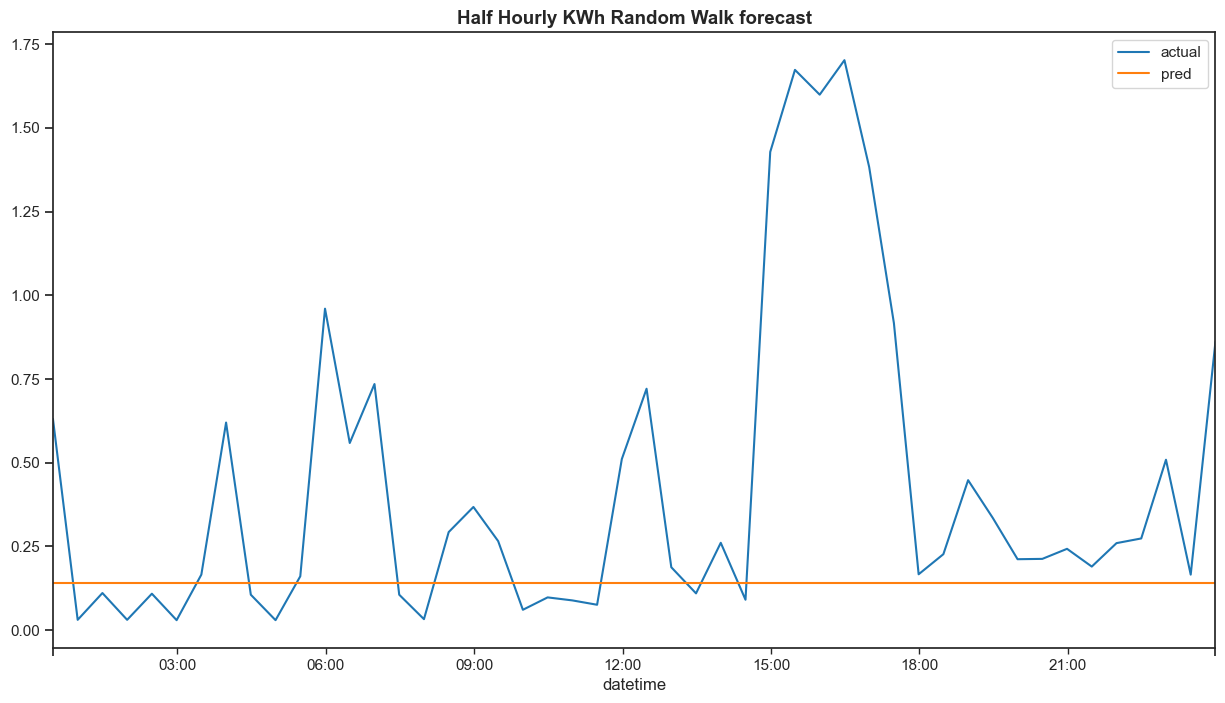

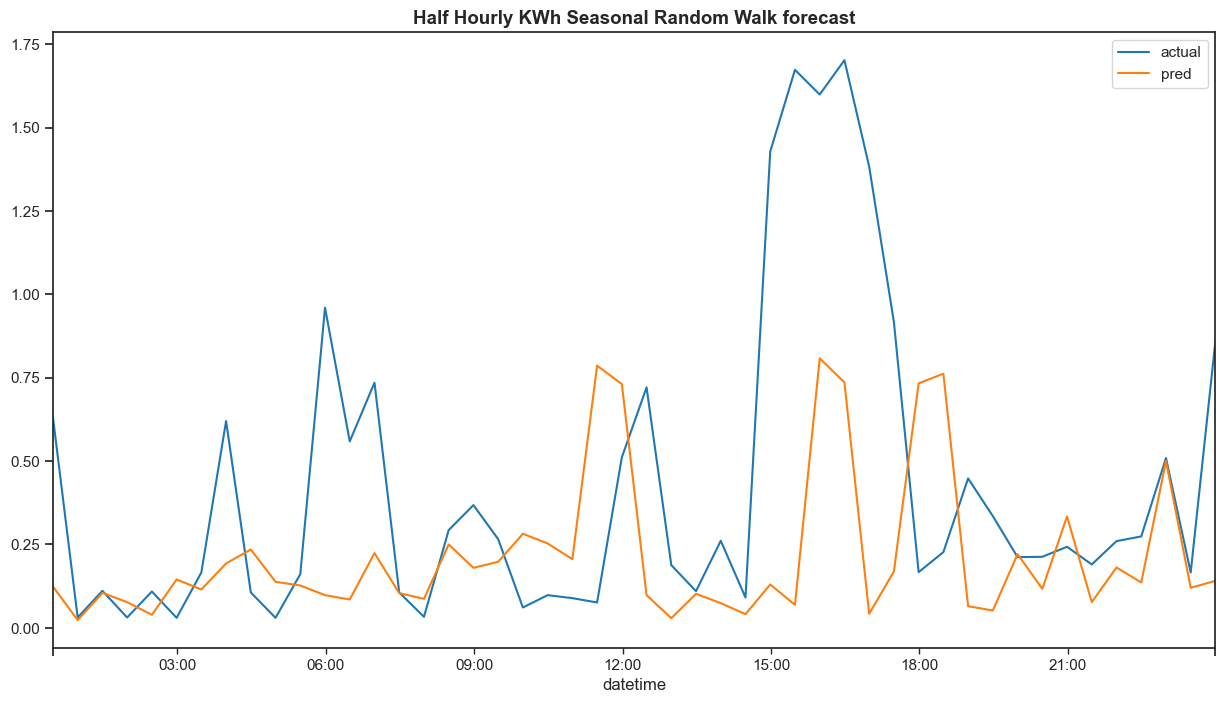

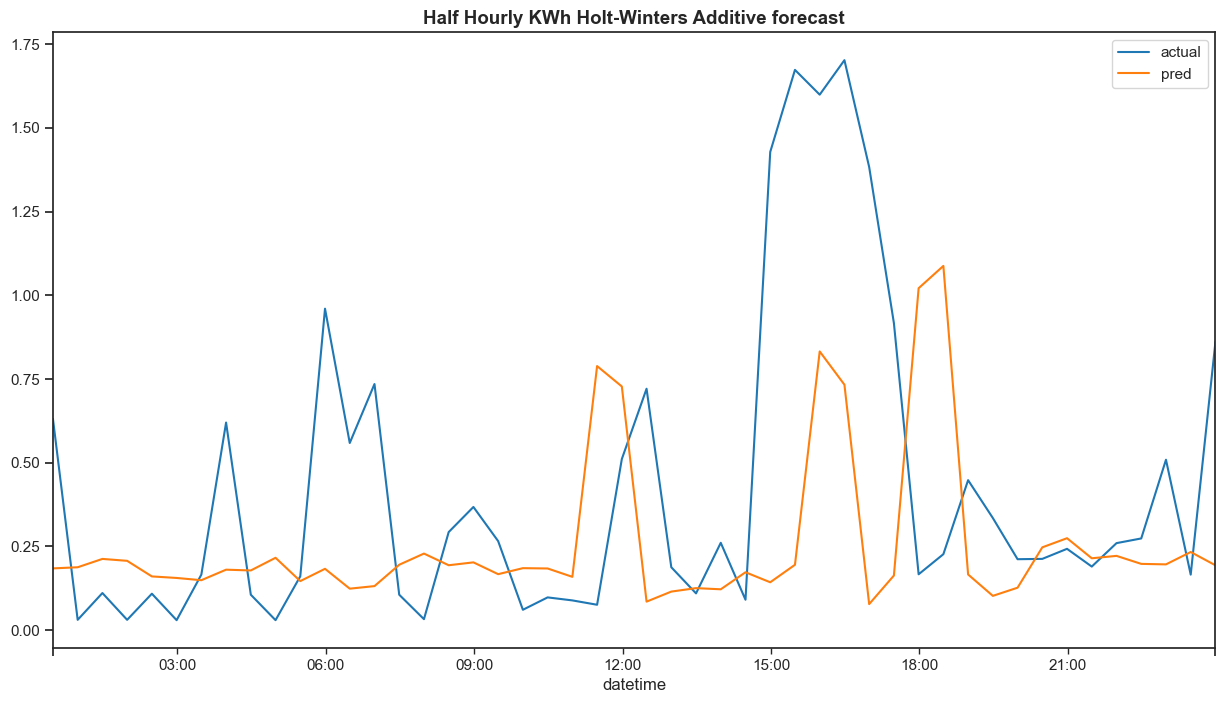

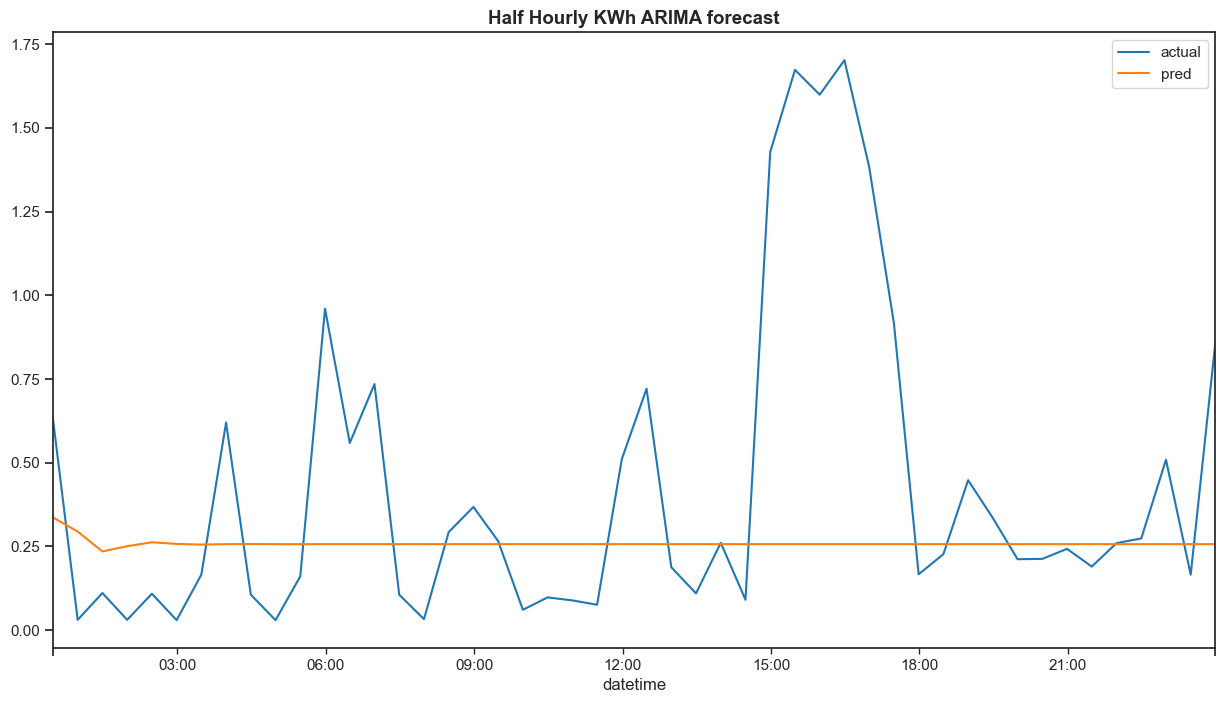

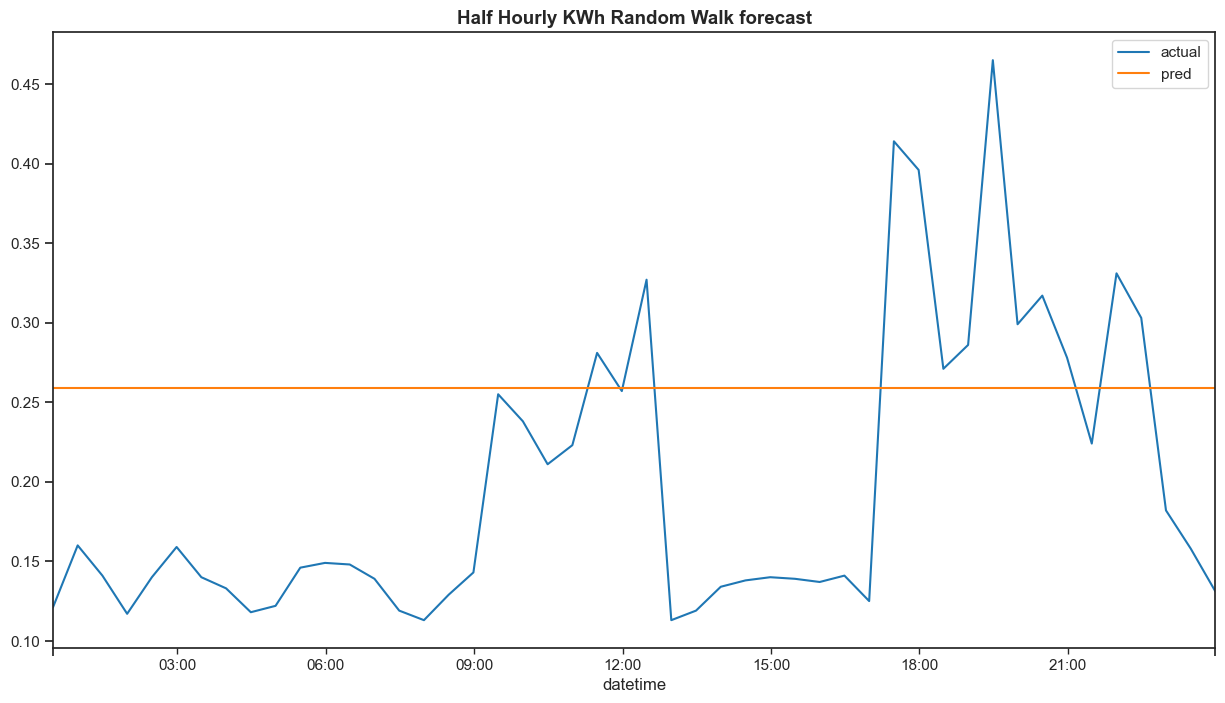

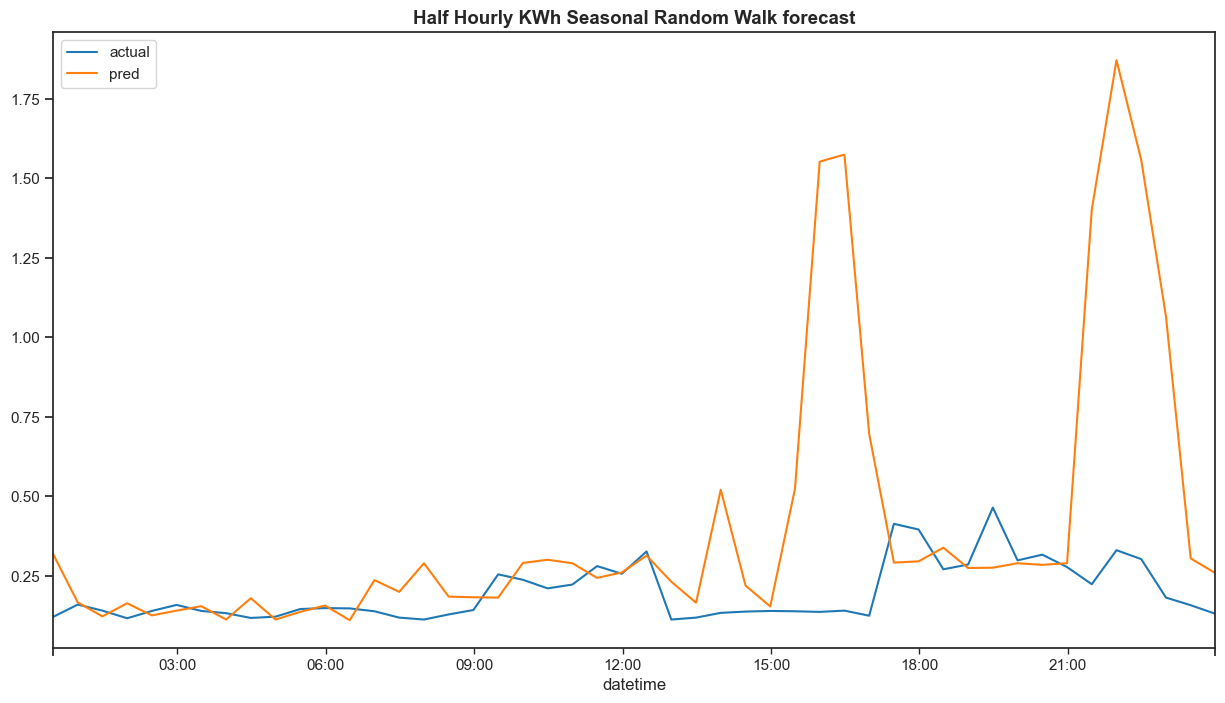

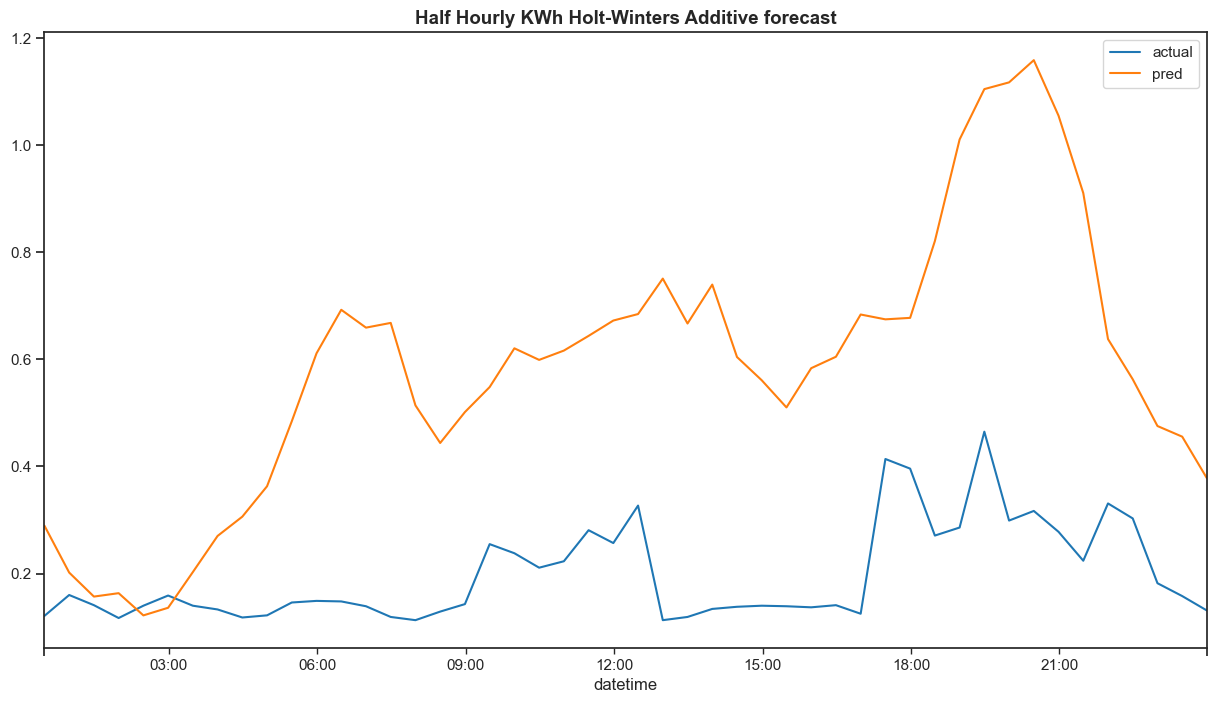

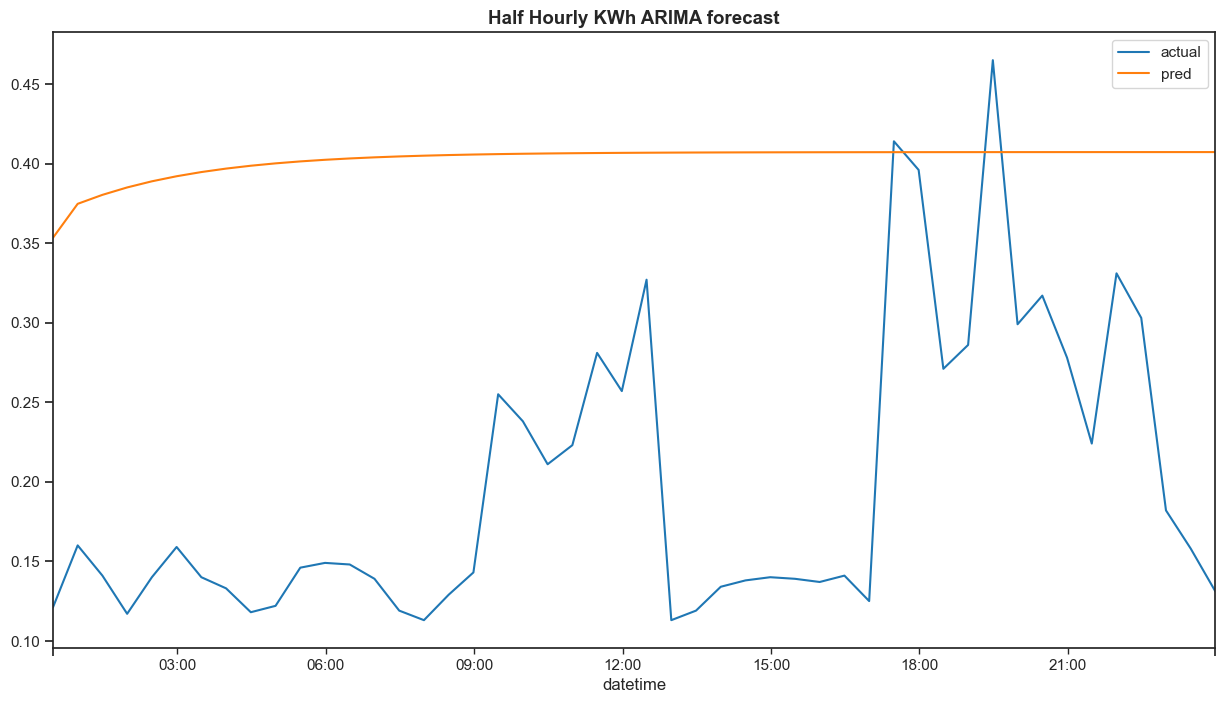

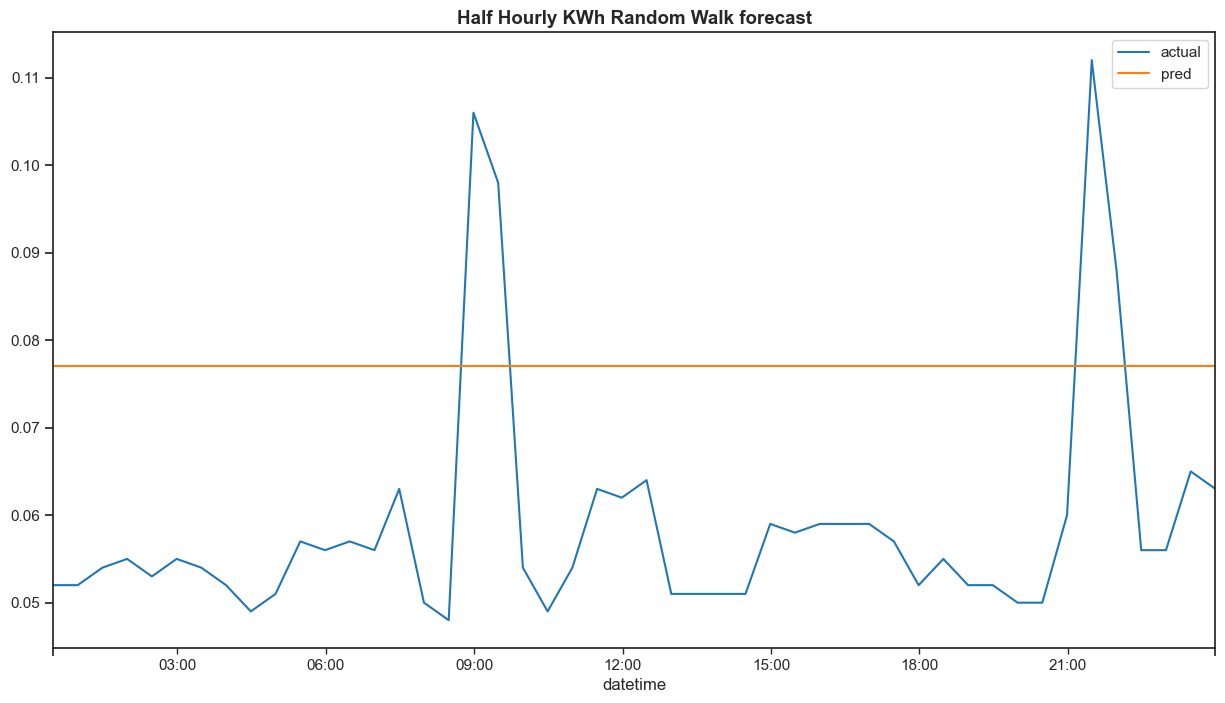

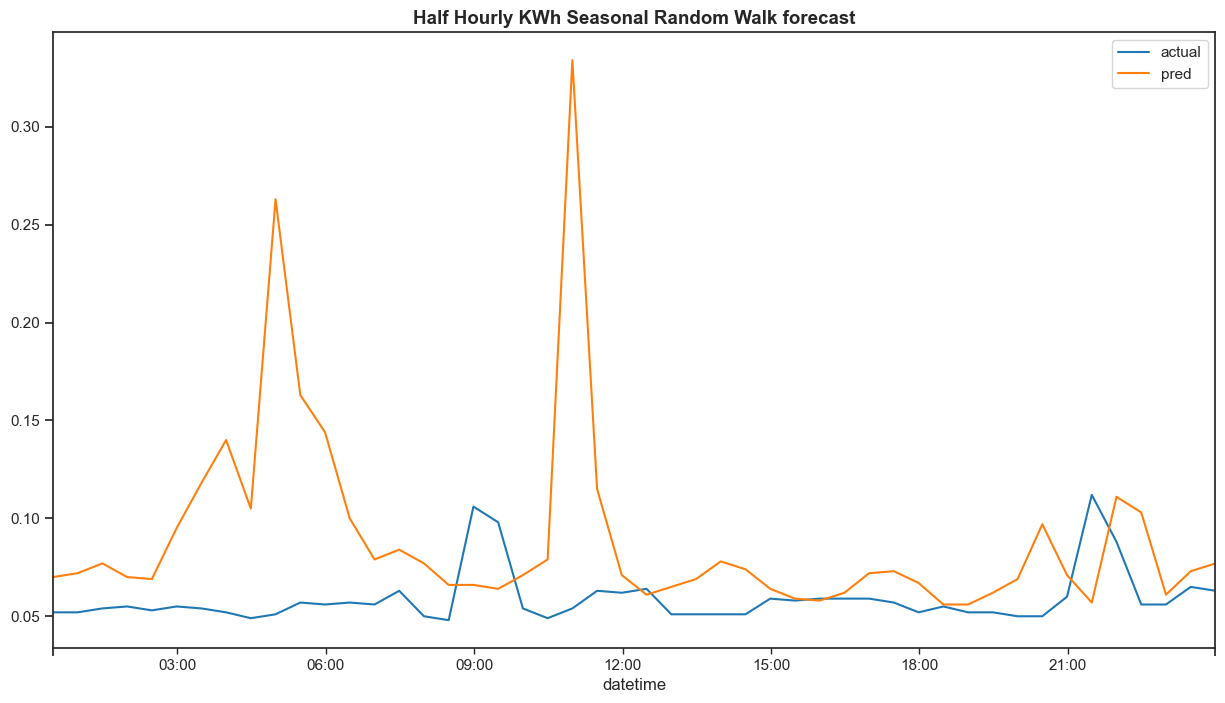

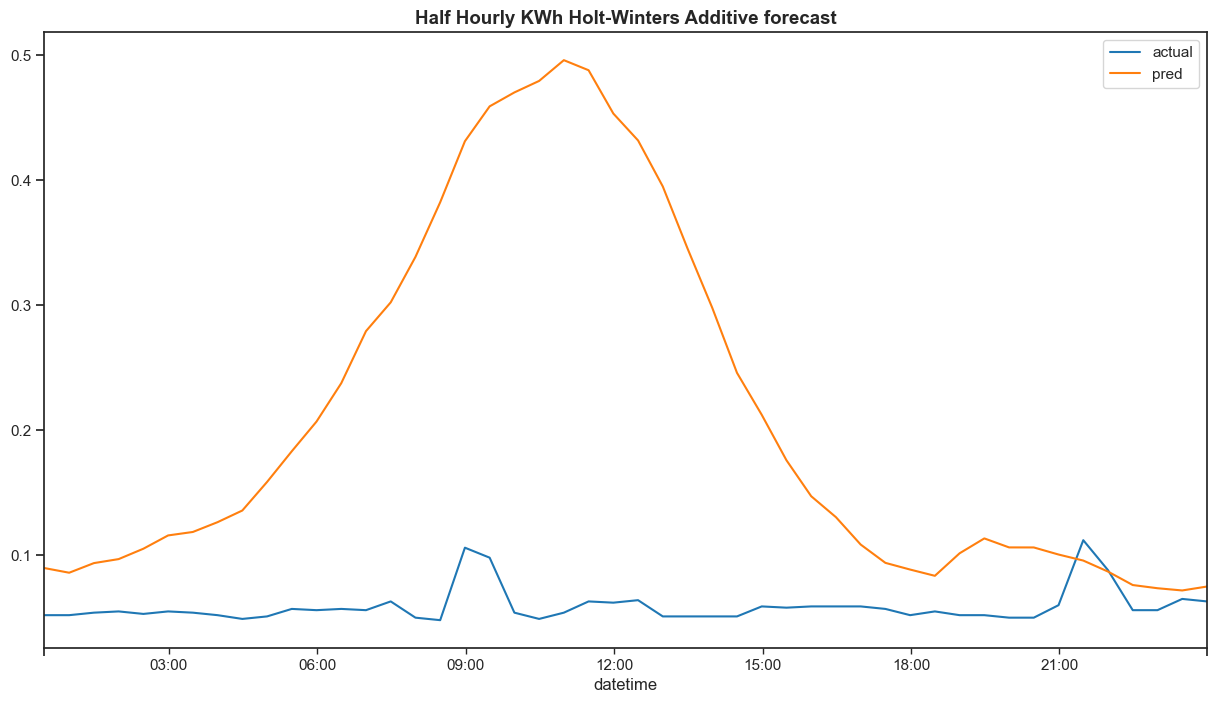

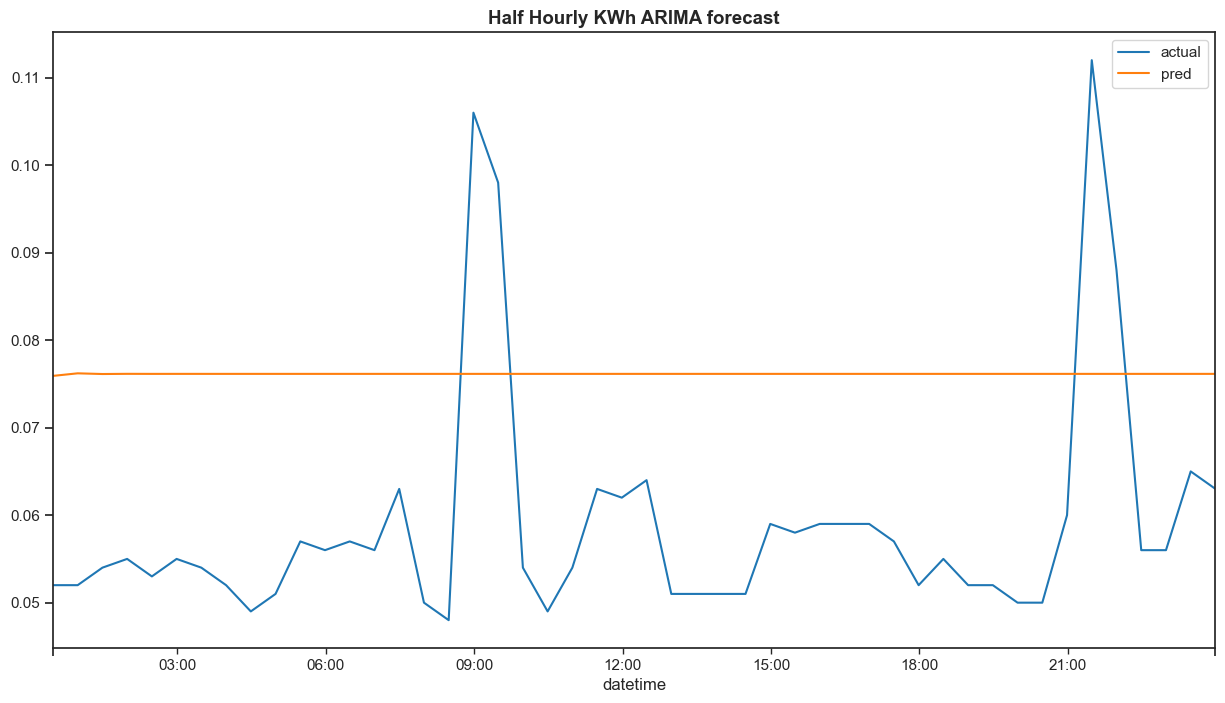

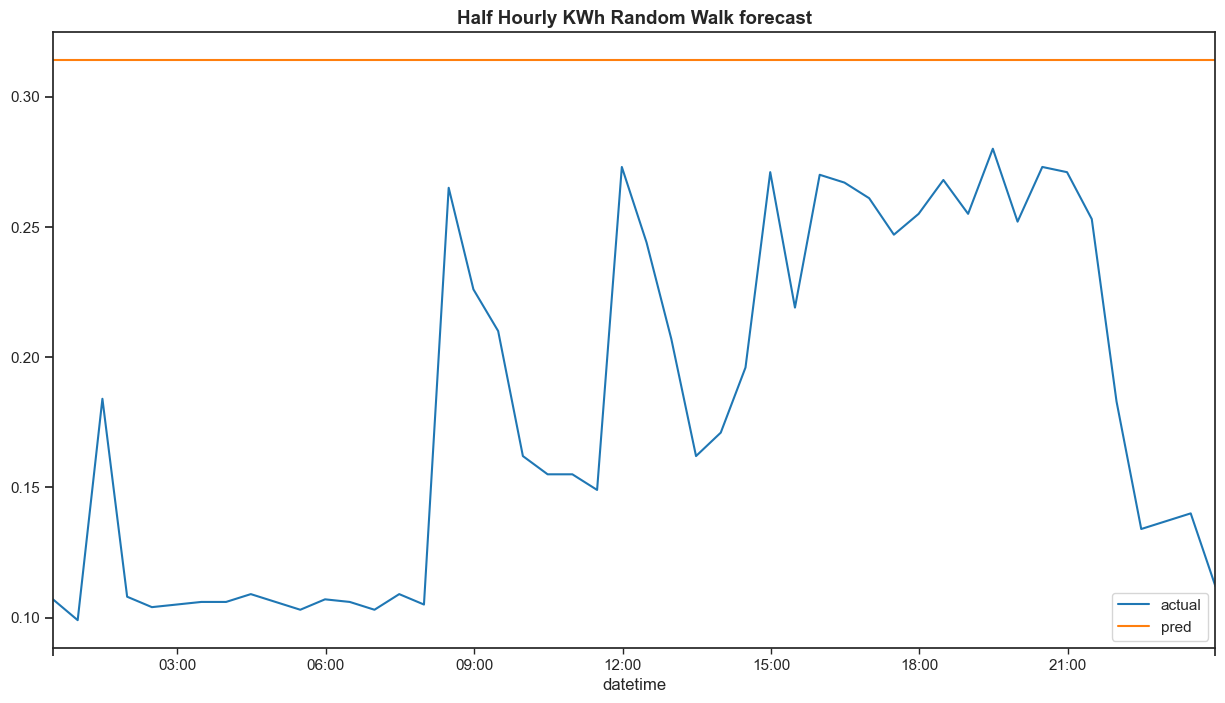

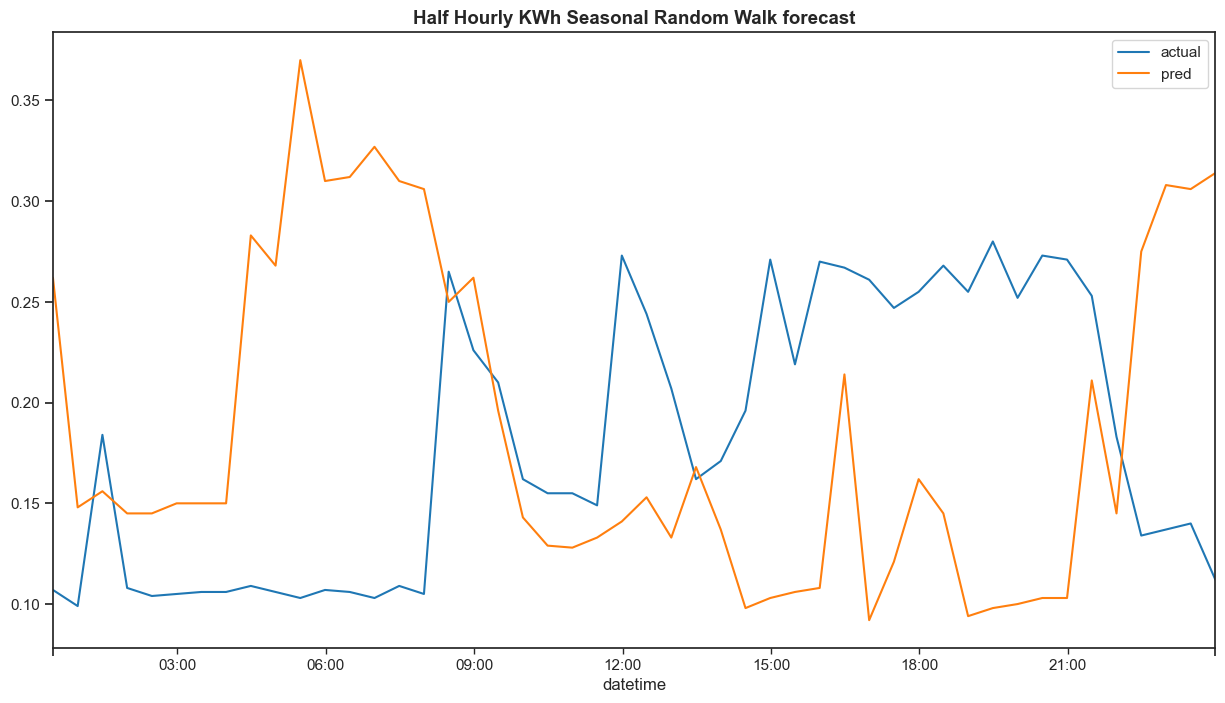

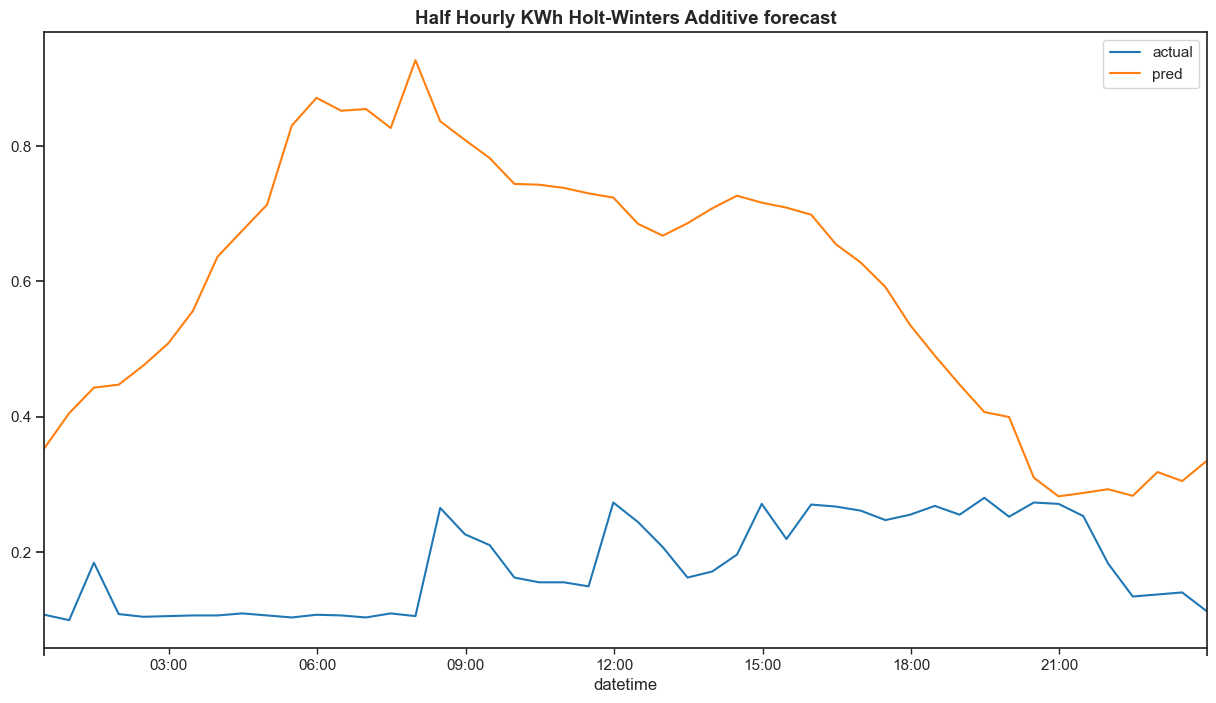

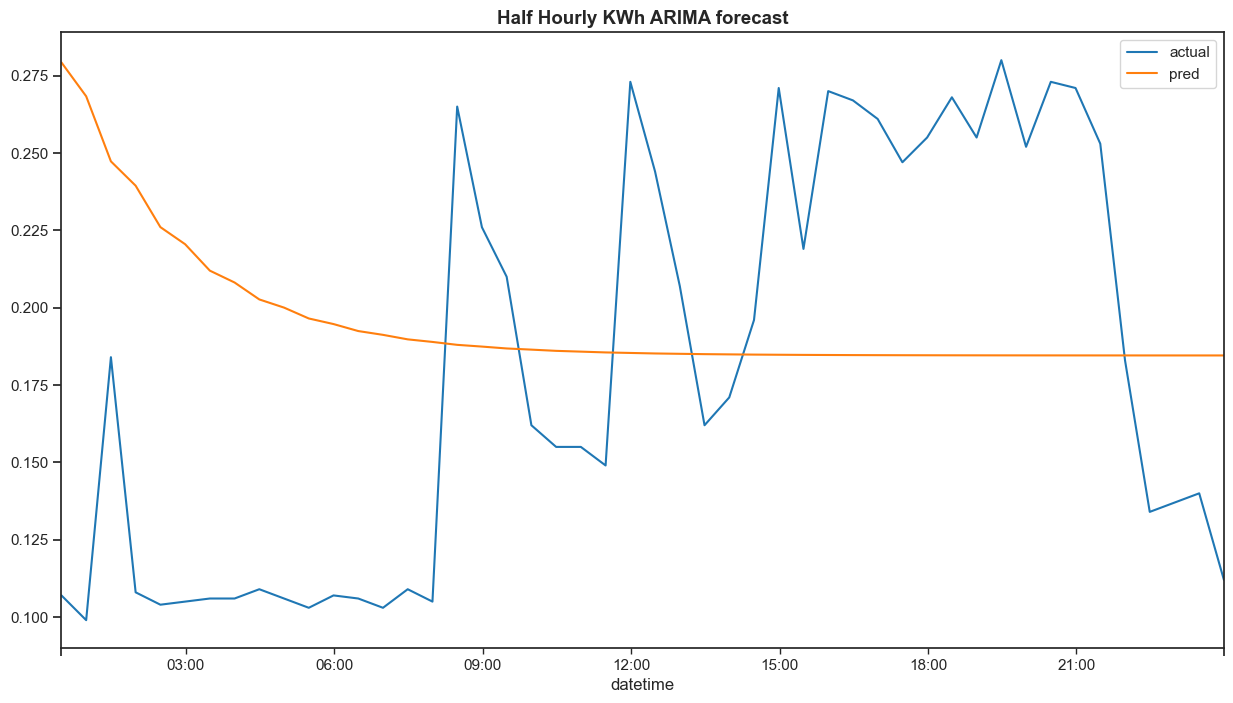

In [26]:
half_hourly_final_results, final_model_half_hourly, final_forecast_half_hourly, report = half_hourly_point_forecast_final_model(original_data)
half_hourly_final_results

Forecast results for half-hourly data are shown below.

In [27]:
print(report)

The final model selected for half-hourly data is Random Walk.
The expected performance on validation set is 0.056643378995433785.
The actual performance on test set is 0.022041666666666668.
The difference between expected and actual performance is 0.03460171232876712.
The point forecast for the next 48 half-hourly data is as follows: 
Random Walk 
2013-06-30 00:00    0.077
2013-06-30 00:30    0.077
2013-06-30 01:00    0.077
2013-06-30 01:30    0.077
2013-06-30 02:00    0.077
2013-06-30 02:30    0.077
2013-06-30 03:00    0.077
2013-06-30 03:30    0.077
2013-06-30 04:00    0.077
2013-06-30 04:30    0.077
2013-06-30 05:00    0.077
2013-06-30 05:30    0.077
2013-06-30 06:00    0.077
2013-06-30 06:30    0.077
2013-06-30 07:00    0.077
2013-06-30 07:30    0.077
2013-06-30 08:00    0.077
2013-06-30 08:30    0.077
2013-06-30 09:00    0.077
2013-06-30 09:30    0.077
2013-06-30 10:00    0.077
2013-06-30 10:30    0.077
2013-06-30 11:00    0.077
2013-06-30 11:30    0.077
2013-06-30 12:00    0.077


## 3.3 Daily Forecast (Automatic methodological approach)

Based on EDA, the 3 models to be tested are:
1. Random walk (baseline model)
2. Damped holt exponential smoothing (since the model is suitable for time series with decreasing trend and no seasonality)
3. ARIMA (flexible model)


### 3.3.1 Interval Forecasting

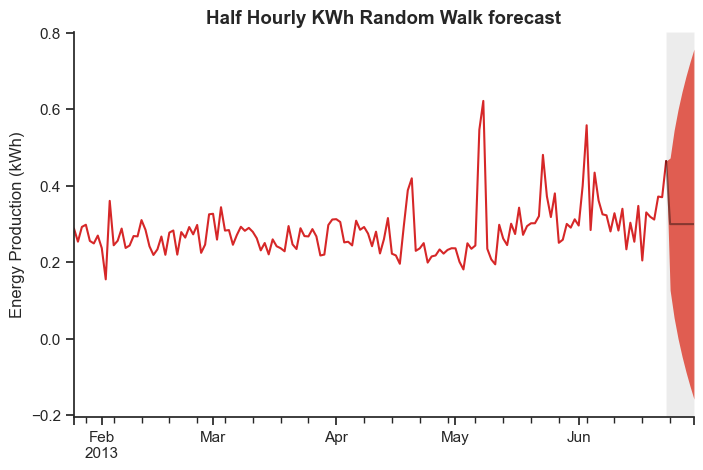

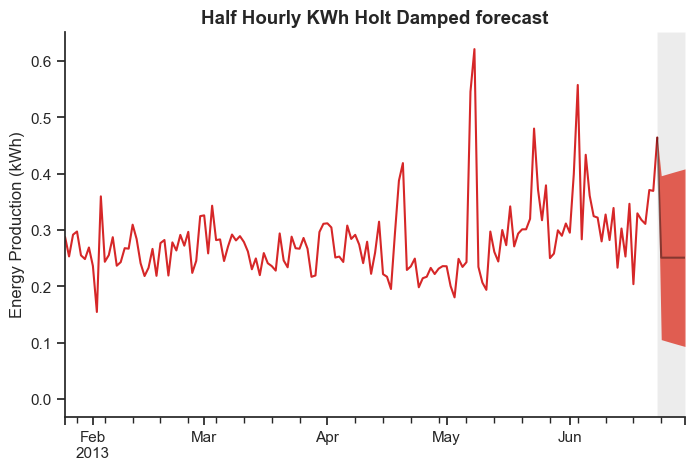

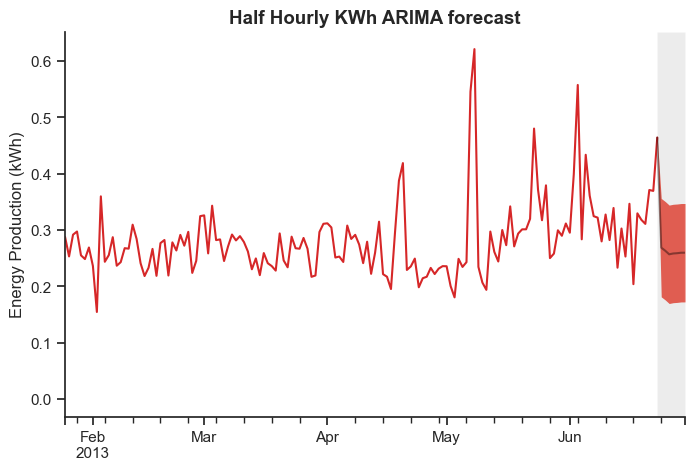

In [28]:
# random walk
random_walk_interval_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)
# damped holt
holt_damp_interval_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)
# arima
ARIMA_interval_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)

### 3.3.2 Point Forecasting

In [29]:
# helper function
def daily_point_forecast_model_selection(daily_ts):
    """ 
        Given the time series for a particular customer and
        return the best model, final forecast, expected performance and actual performance.
    """
    # Step 1: split the data into train, validation and test set
    daily_X_train, daily_X_val, daily_ts_train, daily_ts_val, daily_test_set = split_train_test(daily_ts, test_size=7)

    # Step 2: point forecast using random walk
    pred_rw_daily, exp_mae_rw_daily, act_mae_rw_daily = random_walk_point_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)
    # Step 2.1: plot the forecast against the actual
    plot_forecast_actual(daily_test_set, pred_rw_daily)
    plt.title('Daily KWh Random Walk forecast', fontsize=13.5, fontweight='bold')

    # Step 3: point forecast using holt exponential smoothing
    pred_holt_daily, exp_mae_holt_daily, act_mae_holt_daily = holt_damped_point_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)
    # Step 3.1: plot the forecast against the actual
    plot_forecast_actual(daily_test_set, pred_holt_daily)
    plt.title('Daily KWh Holt Exponential Smoothing forecast', fontsize=13.5, fontweight='bold')

    # Step 4: point forecast using ARIMA
    pred_arima_daily, exp_mae_arima_daily, act_mae_arima_daily = ARIMA_aic_point_forecast(daily_ts_train, daily_ts_val, daily_test_set, 7)
    # Step 4.1: plot the forecast against the actual
    plot_forecast_actual(daily_test_set, pred_arima_daily)
    plt.title('Daily KWh ARIMA forecast', fontsize=13.5, fontweight='bold')

    # Step 5: summarise the model performance
    columns = ['Model Name', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference', 'Forecast']
    daily_results = pd.DataFrame(columns=columns)
    daily_results.loc[0] = ['Random Walk', exp_mae_rw_daily, act_mae_rw_daily, abs(exp_mae_rw_daily-act_mae_rw_daily), pred_rw_daily]
    daily_results.loc[1] = ['Holt Exponential Smoothing', exp_mae_holt_daily, act_mae_holt_daily, abs(exp_mae_holt_daily-act_mae_holt_daily), pred_holt_daily]
    daily_results.loc[2] = ['ARIMA', exp_mae_arima_daily, act_mae_arima_daily, abs(exp_mae_arima_daily-act_mae_arima_daily), pred_arima_daily]
    daily_results.round(4)

    # Step 6: final model selection and final forecast
    daily_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)
    final_model = daily_results.iloc[0,0]
    final_forecast = daily_results.iloc[0,4]

    # Step 7: Report important information
    report = (
        f'The final model selected for daily data is {final_model}.' + '\n' +
        f'The expected performance on validation set is {daily_results.iloc[0,1]}.' + '\n' +
        f'The actual performance on test set is {daily_results.iloc[0,2]}.' + '\n' +
        f'The difference between expected and actual performance is {daily_results.iloc[0,3]}.' + '\n'
        f'The point forecast for the next 7 days is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model} \n' +
        f'{final_forecast} \n' +
        "======================================================================================================"
    )

    return final_model, final_forecast, daily_results, report

In [30]:
# final daily point forecast model selection
def daily_point_forecast_final_model(original_data):
    """
        Given the time series,
        return the point forecast using the best model.
        assume the original data is half-hourly data
    """
    # Step 0: make a copy of the original dataset and convert the index to period
    data = original_data.copy()
    if not isinstance(data.index, pd.PeriodIndex):
        data.index = data.index.to_period(freq='30min')
    # Step 1: aggregate the data to daily data
    daily_data = data.groupby('Customer').resample('D').mean()
    # examine any missing values
    if daily_data.isnull().sum().sum() > 0:
        # Last Observation Carried Forward (LOCF).
        impute_missing_values(daily_data)
    daily_data.index = daily_data.index.droplevel(0)
    if not isinstance(daily_data.index, pd.PeriodIndex):
        daily_data.index = daily_data.index.to_period(freq='D')

    # Step 2: Series of each customer
    columns = ['Customer', 'Final Model', 'Final Forecast', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference']
    daily_final_results = pd.DataFrame(columns=columns)
    customers = daily_data["Customer"].unique()
    customers = [customer for customer in customers if not np.isnan(customer)]  # This will exclude NaN values

    # extract series of each customer
    i = 0
    for c in customers:
        daily_c = daily_data[daily_data['Customer'] == c]
        final_model, final_forecast, daily_results, report = daily_point_forecast_model_selection(daily_c)
        daily_final_results.loc[i] = [f'Customer {c}', final_model, final_forecast, daily_results.iloc[0,1], daily_results.iloc[0,2], daily_results.iloc[0,3]]
        i += 1
    
    # Step 3: order the customers based on aforementioned criteria
    daily_final_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)

    # Step 4: "best" model for daily data
    final_model_daily = daily_final_results.iloc[0,1]
    final_forecast_daily = daily_final_results.iloc[0,2]

    # Step 5: report the final results
    report = (
        f'The final model selected for daily data is {final_model_daily}.' + '\n' +
        f'The expected performance on validation set is {daily_final_results.iloc[0,3]}.' + '\n' +
        f'The actual performance on test set is {daily_final_results.iloc[0,4]}.' + '\n' +
        f'The difference between expected and actual performance is {daily_final_results.iloc[0,5]}.' + '\n'
        f'The point forecast for the next 7 days is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model_daily} \n' +
        f'{final_forecast_daily} \n' +
        "======================================================================================================"
    )

    return daily_final_results, final_model_daily, final_forecast_daily, report

### 3.3.3 Forecast Results for daily data

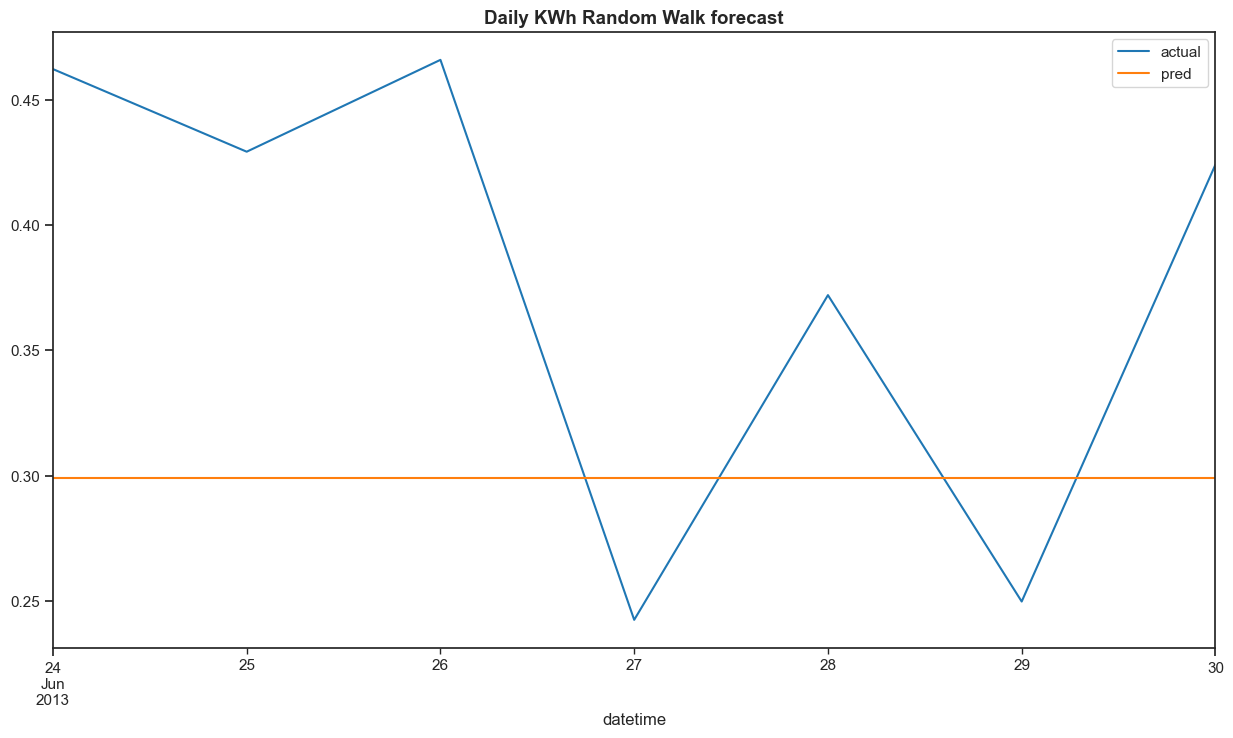

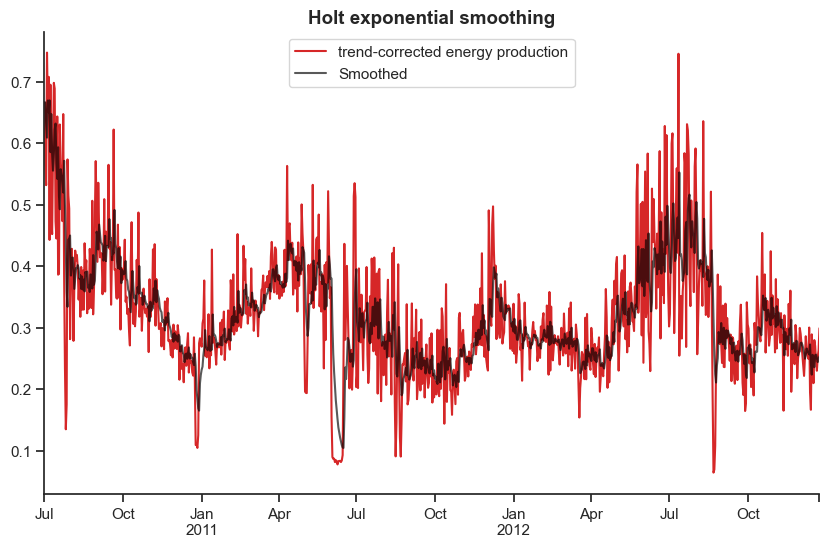

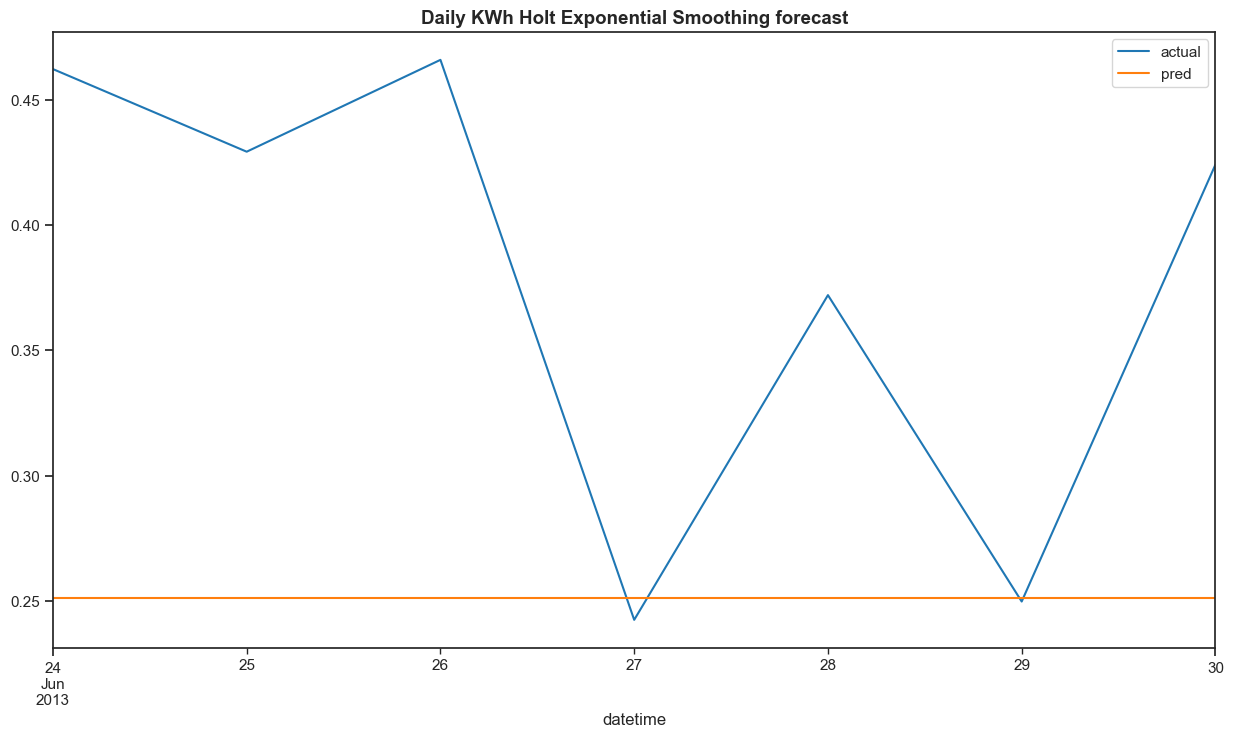

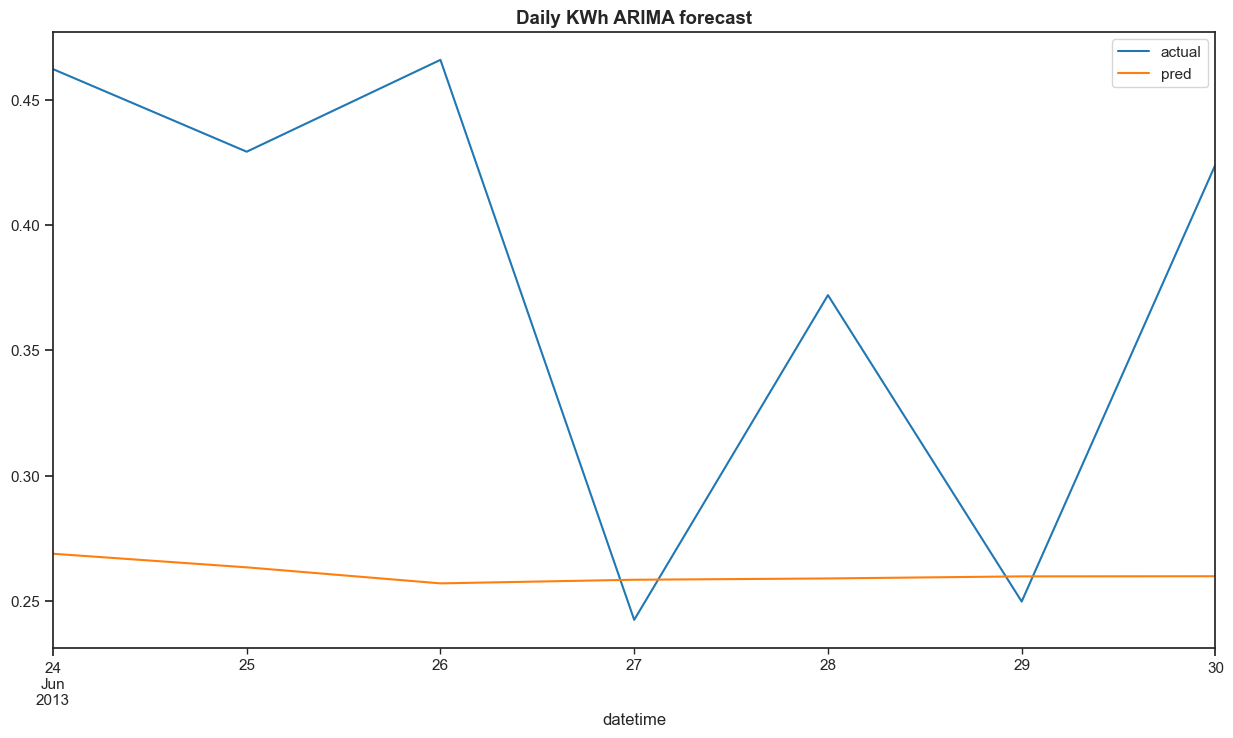

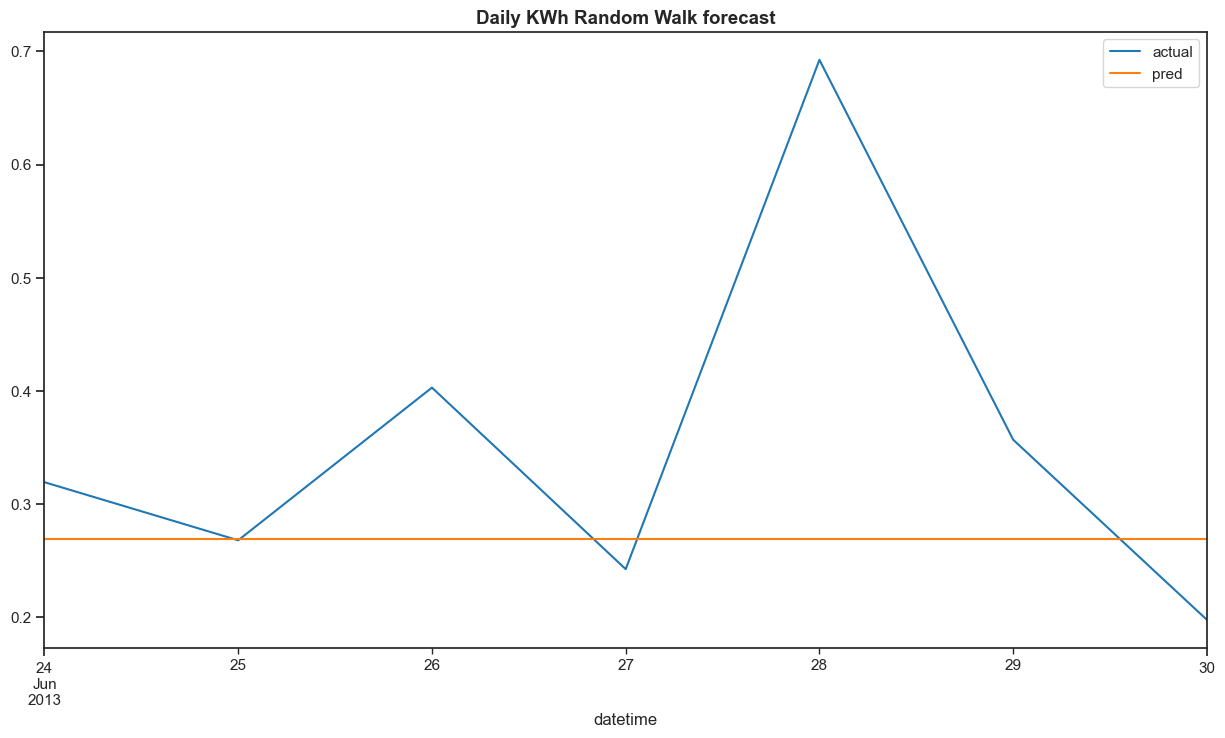

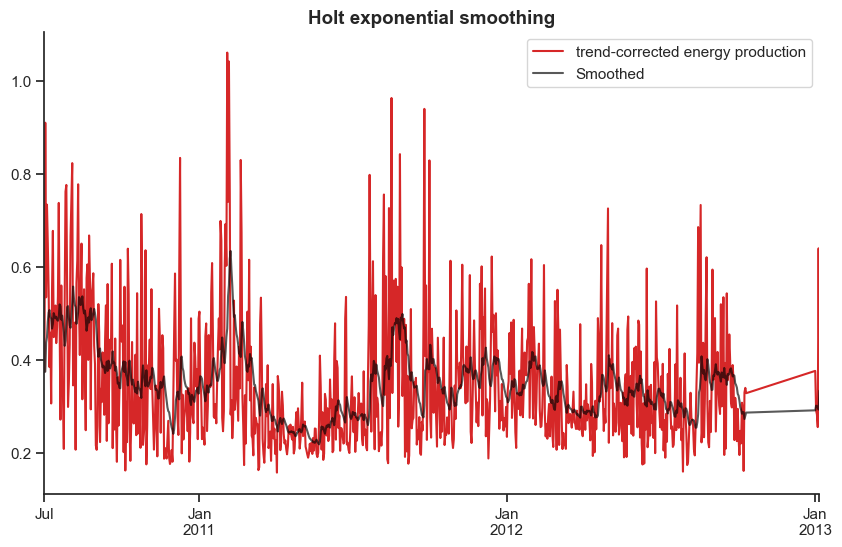

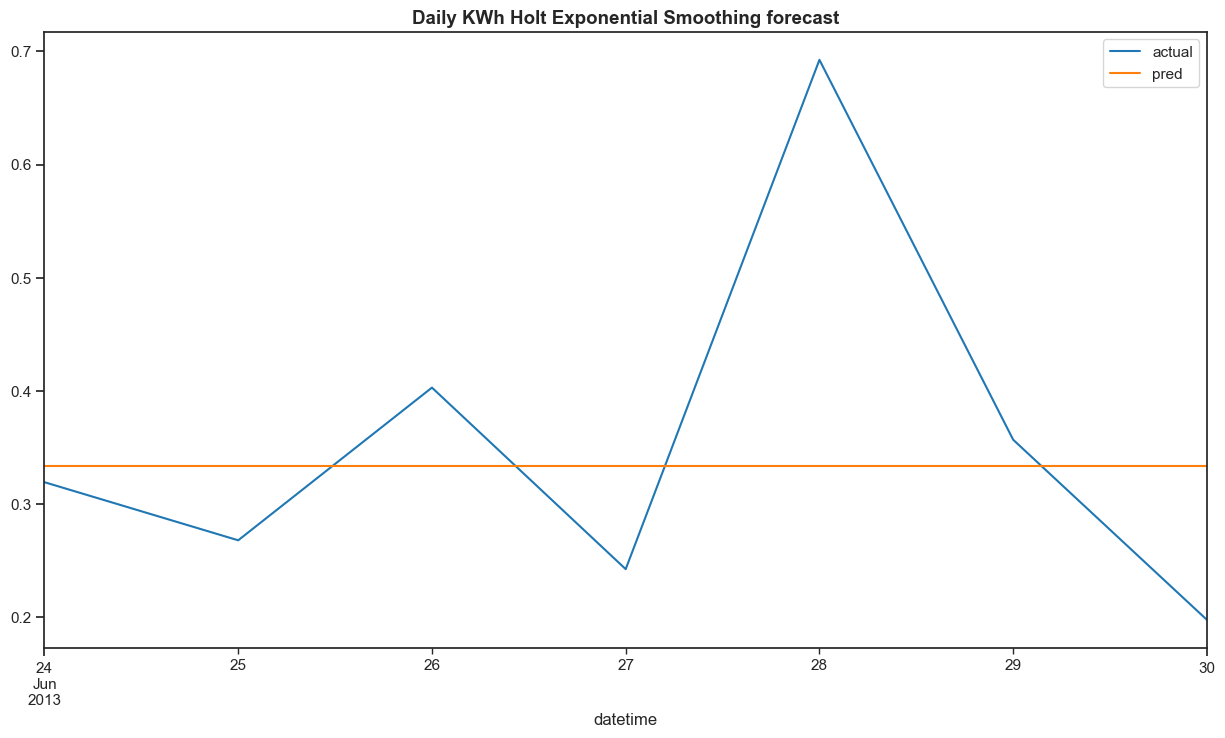

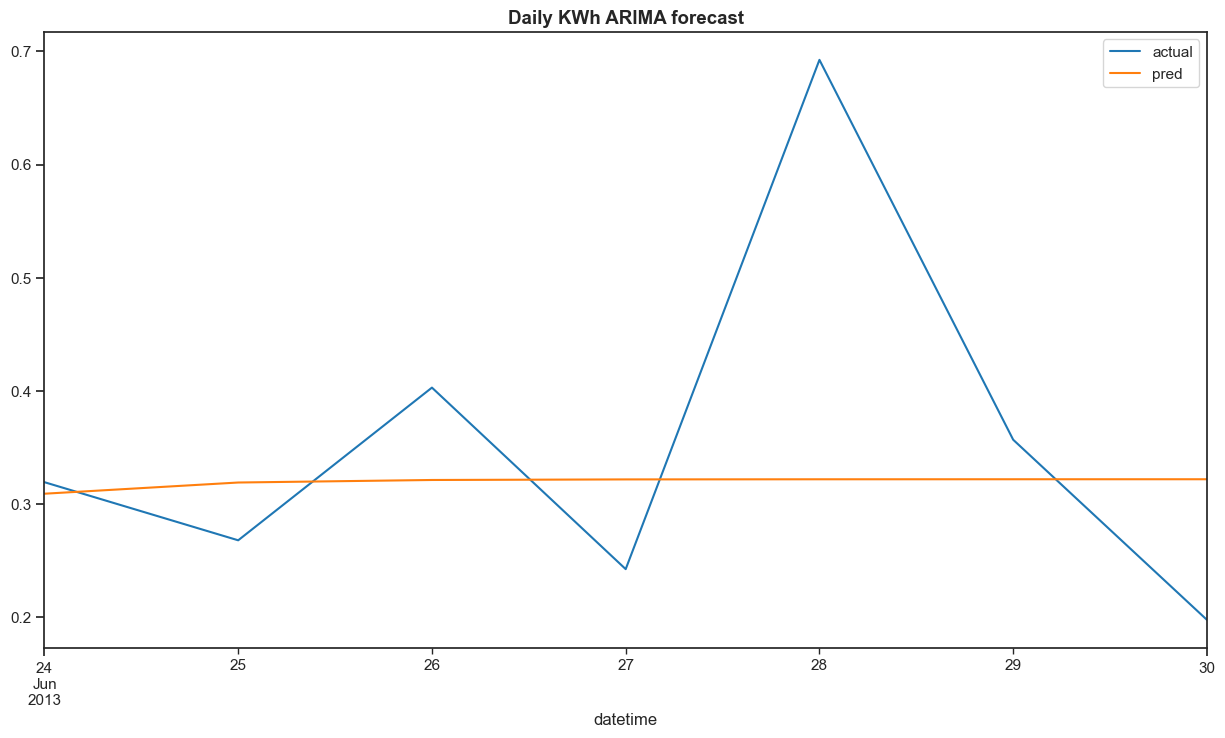

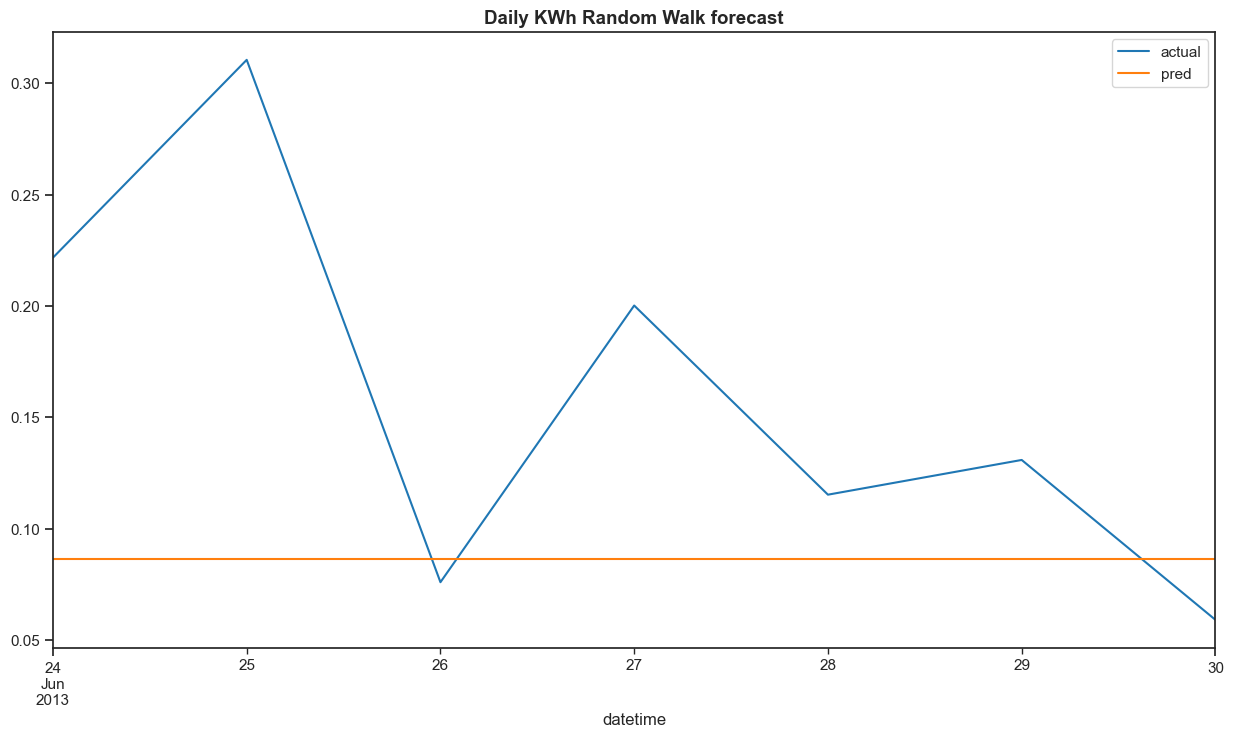

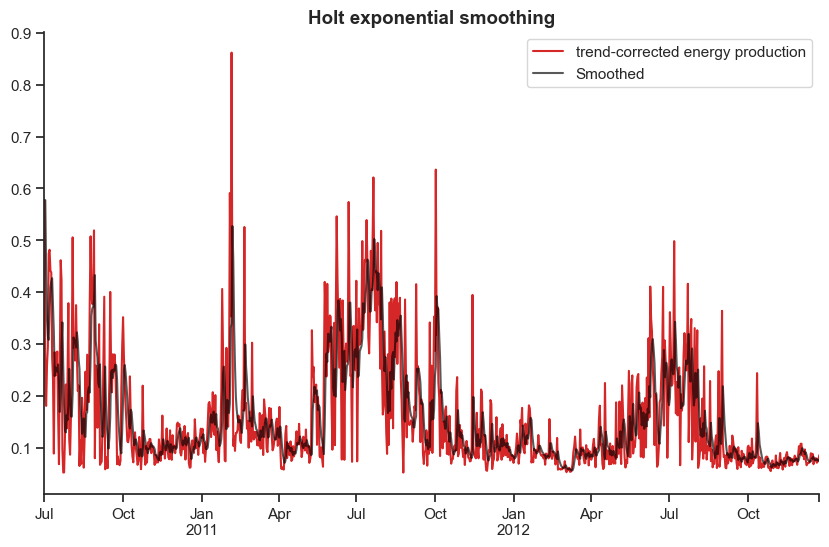

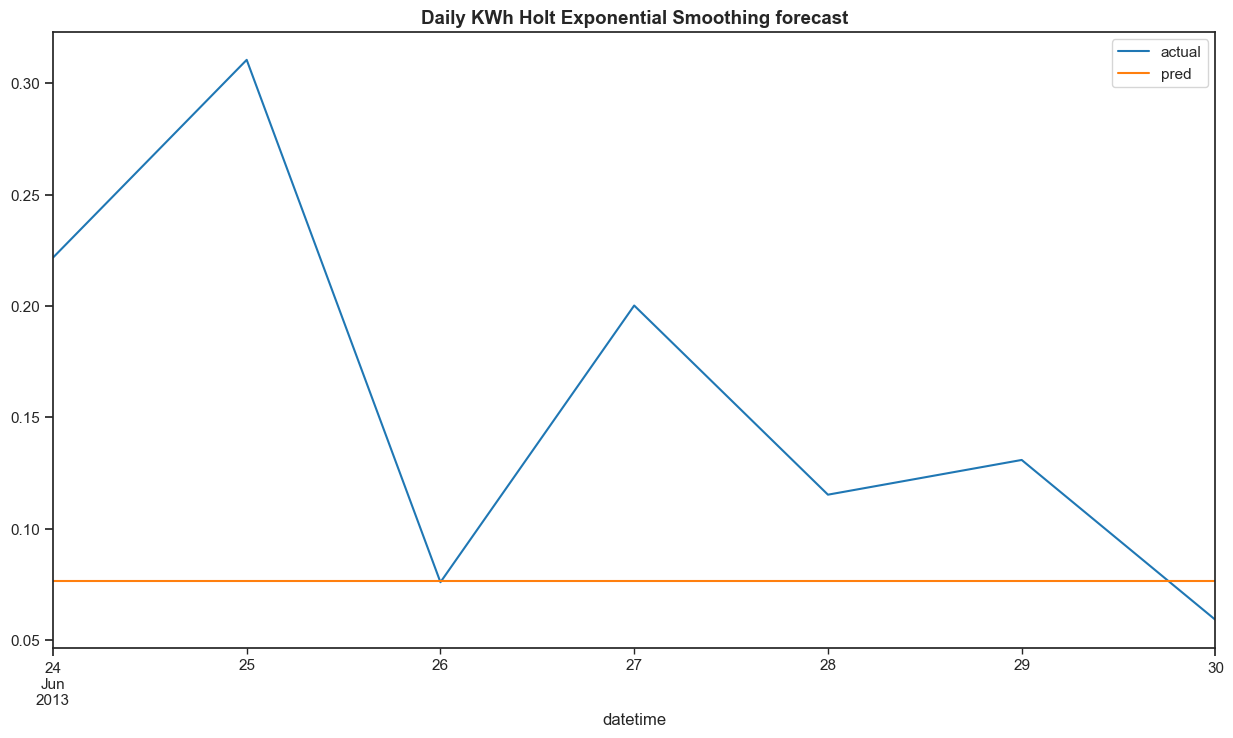

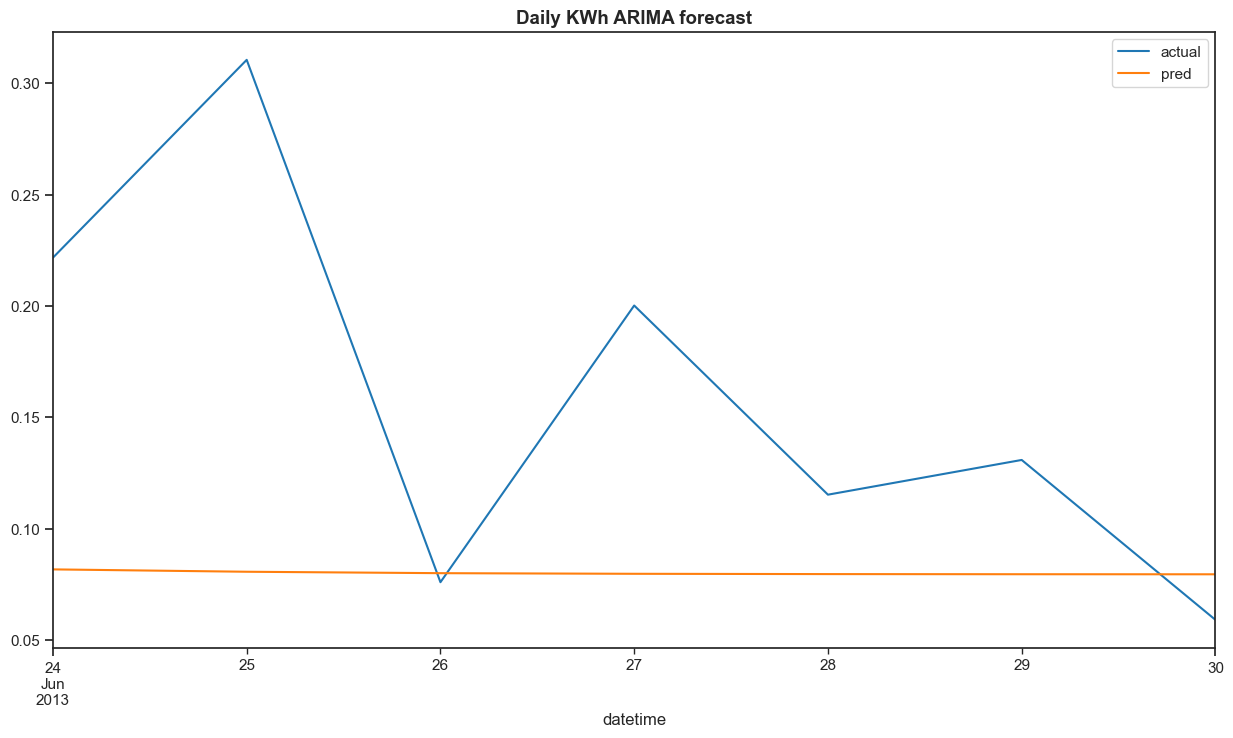

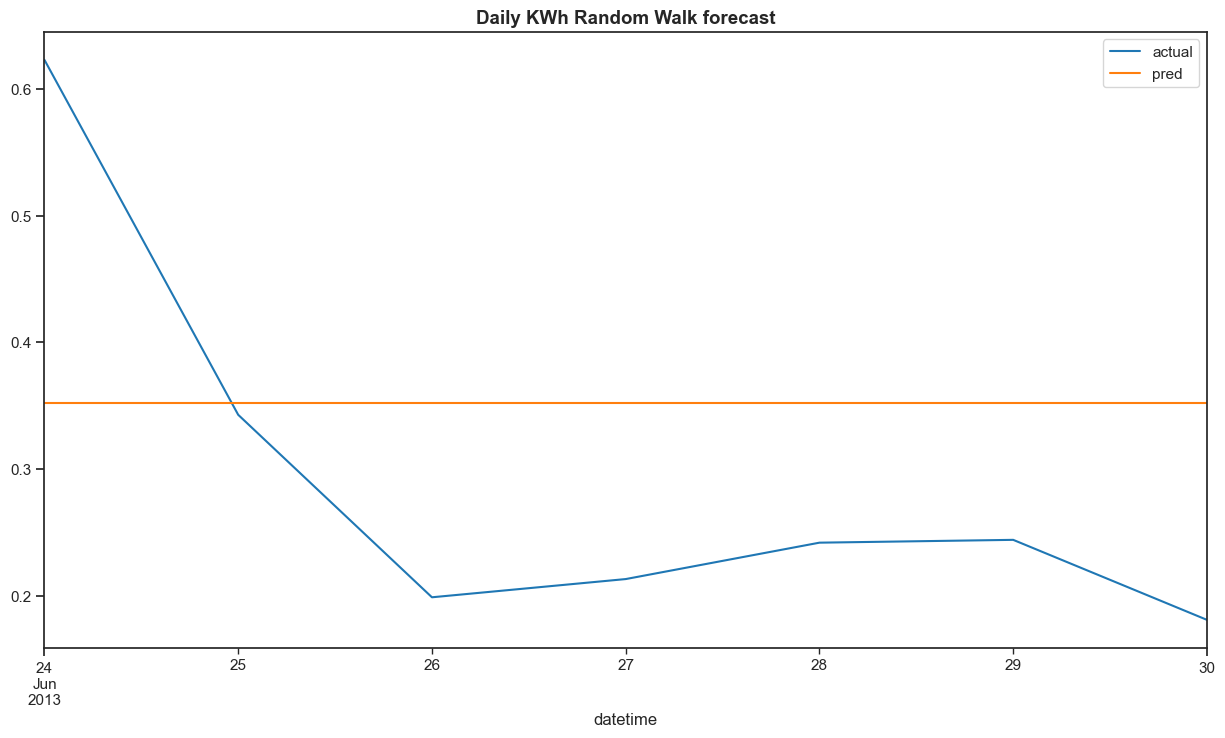

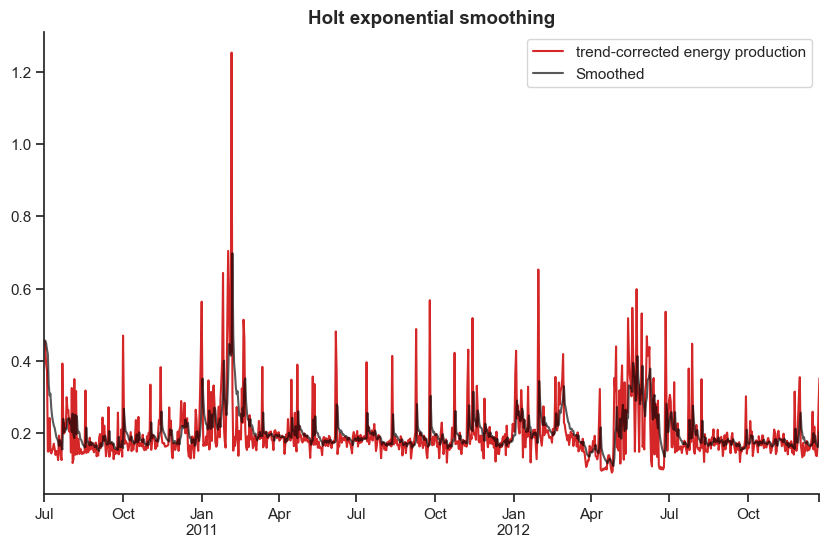

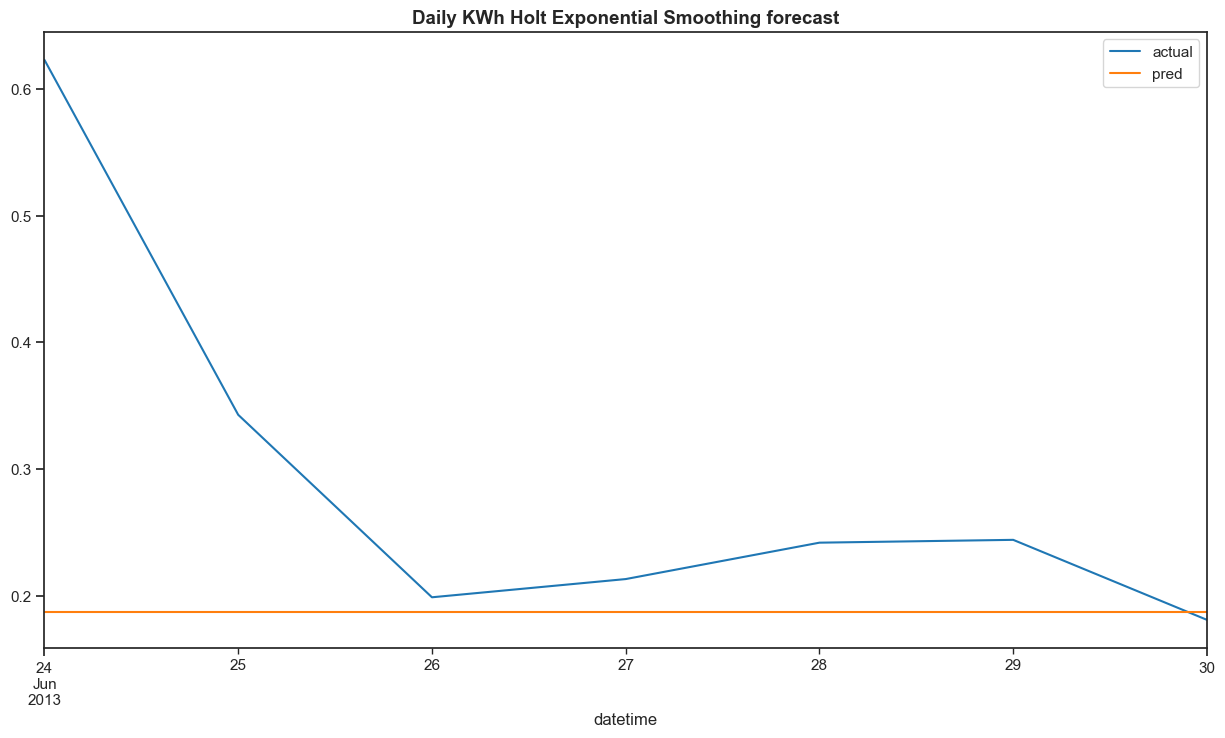

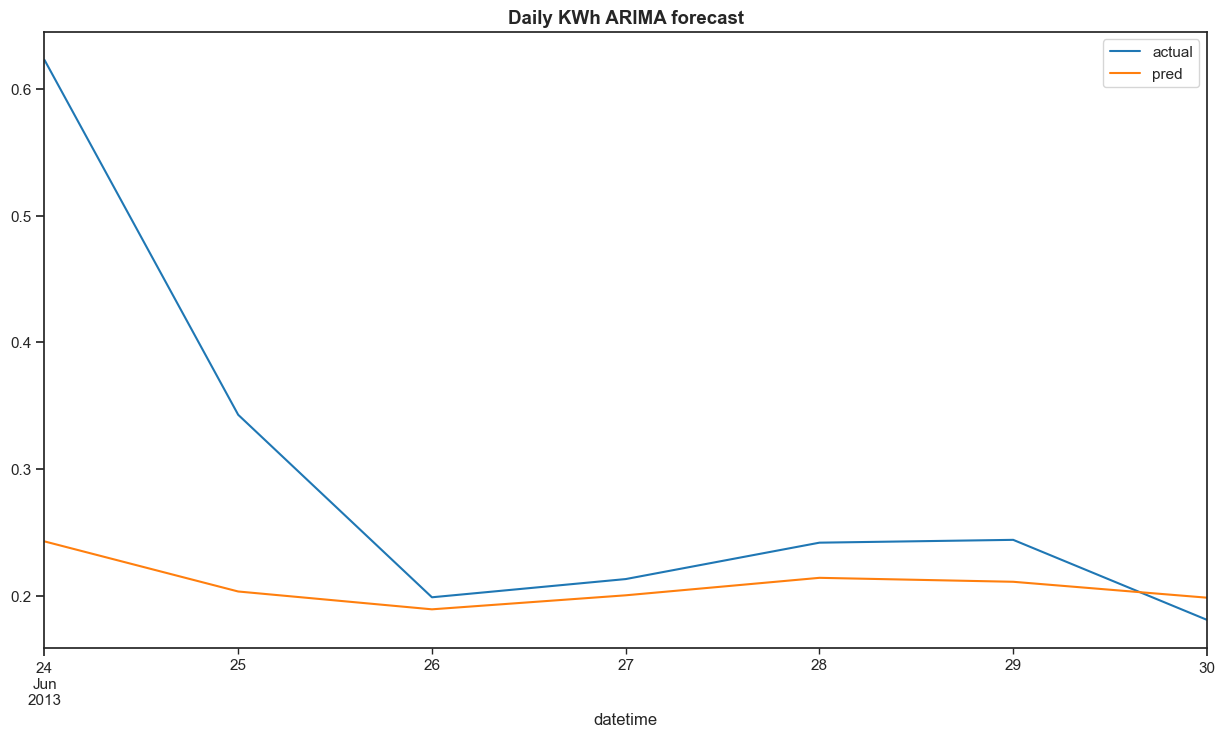

In [31]:
daily_final_results, final_model_daily, final_forecast_daily, report = daily_point_forecast_final_model(original_data)

In [32]:
print(report)

The final model selected for daily data is Holt Exponential Smoothing.
The expected performance on validation set is 0.03314308489678367.
The actual performance on test set is 0.08774037616911971.
The difference between expected and actual performance is 0.05459729127233604.
The point forecast for the next 7 days is as follows: 
Holt Exponential Smoothing 
2013-06-24    0.076509
2013-06-25    0.076509
2013-06-26    0.076509
2013-06-27    0.076509
2013-06-28    0.076509
2013-06-29    0.076509
2013-06-30    0.076509
Freq: D, dtype: float64 


## 3.4 Monthly data (Automatic methodological approach)

Based on EDA, the 4 models to be tested are:

1. Random walk (baseline model)
2. Seasonal random walk (since strong seasonality is observed)
3. Holt-Winter's exponential smoothing with multiplicative seasonality
4. ARIMA (flexible model)

### 3.4.1 Interval Forecasting

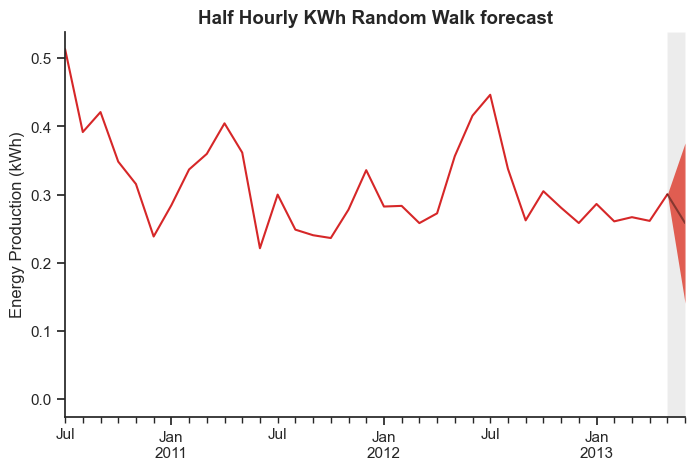

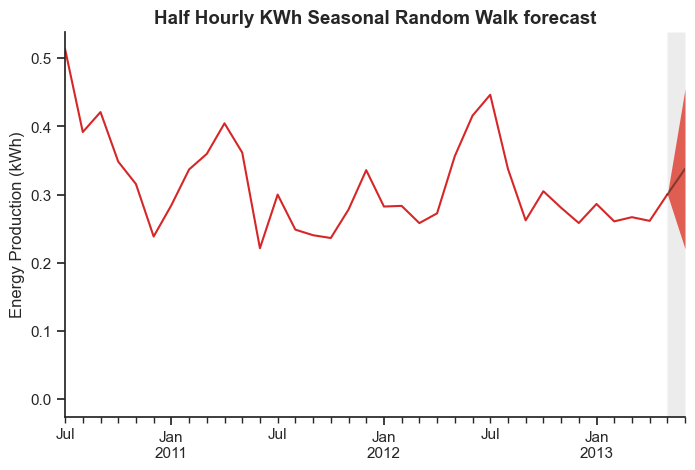

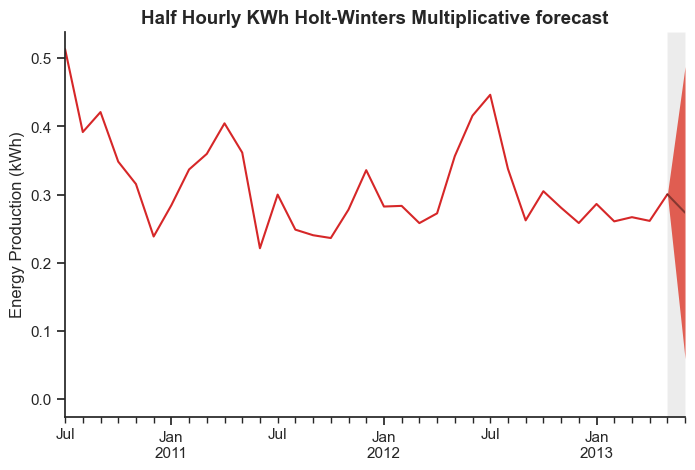

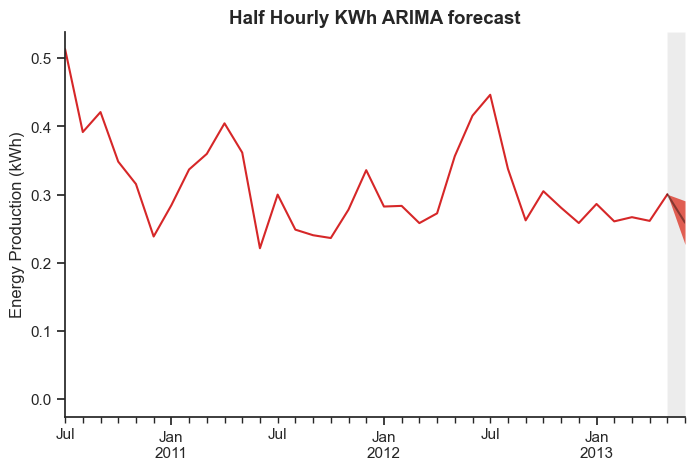

In [33]:
# random walk
random_walk_interval_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)
# seasonal random walk
seasonal_random_walk_interval_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)
# holt multiplicative
holt_winter_mul_interval_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)
# arima
ARIMA_interval_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

### 3.4.2 Point Forecast

In [34]:
# Point forecast for next 1 month
## random walk
pred_rw_monthly, exp_mae_rw_monthly, act_mae_rw_monthly = random_walk_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

## seasonal random walk
pred_srw_monthly, exp_mae_srw_monthly, act_mae_srw_monthly = seasonal_random_walk_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

## Holt-Winters multiplicative
pred_holt_mul_monthly, exp_mae_holt_mul_monthly, act_mae_holt_mul_monthly = holt_winters_multiplicative_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

## arima
pred_arima_monthly, exp_mae_arima_monthly, act_mae_arima_monthly = ARIMA_aic_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

In [35]:
def monthly_point_forecast_model_selection(monthly_ts):
    """
        Given the time series for a particular customer and
        return the best model, final forecast, expected performance and actual performance.
    """
    # Step 1: split the data into train, validation and test set
    monthly_X_train, monthly_X_val, monthly_ts_train, monthly_ts_val, monthly_test_set = split_train_test(monthly_ts, test_size=1)

    # Step 2: random walk
    pred_rw_monthly, exp_mae_rw_monthly, act_mae_rw_monthly = random_walk_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)
    
    # Step 3: seasonal random walk
    pred_srw_monthly, exp_mae_srw_monthly, act_mae_srw_monthly = seasonal_random_walk_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

    # Step 4: Holt-Winters multiplicative
    pred_holt_mul_monthly, exp_mae_holt_mul_monthly, act_mae_holt_mul_monthly = holt_winters_multiplicative_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)

    # Step 5: ARIMA
    pred_arima_monthly, exp_mae_arima_monthly, act_mae_arima_monthly = ARIMA_aic_point_forecast(monthly_ts_train, monthly_ts_val, monthly_test_set, 1)
    
    # Step 6: summarise the model performance
    columns = ['Model Name', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference', 'Forecast']
    monthly_results = pd.DataFrame(columns=columns)
    monthly_results.loc[0] = ['Random Walk', exp_mae_rw_monthly, act_mae_rw_monthly, abs(exp_mae_rw_monthly-act_mae_rw_monthly), pred_rw_monthly]
    monthly_results.loc[1] = ['Seasonal Random Walk', exp_mae_srw_monthly, act_mae_srw_monthly, abs(exp_mae_srw_monthly-act_mae_srw_monthly), pred_srw_monthly]
    monthly_results.loc[2] = ['Holt-Winters Multiplicative', exp_mae_holt_mul_monthly, act_mae_holt_mul_monthly, abs(exp_mae_holt_mul_monthly-act_mae_holt_mul_monthly), pred_holt_mul_monthly]
    monthly_results.loc[3] = ['ARIMA', exp_mae_arima_monthly, act_mae_arima_monthly, abs(exp_mae_arima_monthly-act_mae_arima_monthly), pred_arima_monthly]
    monthly_results.round(4)

    # Step 7: final model selection and final forecast
    monthly_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)
    final_model = monthly_results.iloc[0,0]
    final_forecast = monthly_results.iloc[0,4]

    # Step 8: Report important information
    report = (
        f'The final model selected for monthly data is {final_model}.' + '\n' +
        f'The expected performance on validation set is {monthly_results.iloc[0,1]}.' + '\n' +
        f'The actual performance on test set is {monthly_results.iloc[0,2]}.' + '\n' +
        f'The difference between expected and actual performance is {monthly_results.iloc[0,3]}.' + '\n'
        f'The point forecast for the next month is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model} \n' +
        f'{final_forecast} \n' +
        "======================================================================================================"
    )

    return final_model, final_forecast, monthly_results, report
    

In [36]:
# final monthly point forecast model selection
def monthly_point_forecast_final_model(original_data):
    """
        Given the time series,
        return the point forecast using the best model.
        Assume the original data is half-hourly data
    """
    # Step 0: make a copy of the original dataset and convert the index to period
    data = original_data.copy()
    if not isinstance(data.index, pd.PeriodIndex):
        data.index = data.index.to_period(freq='30min')
    
    # Step 1: aggregate the data to monthly data
    monthly_data = data.groupby('Customer').resample('M').mean()
    # examine any missing values
    if monthly_data.isnull().sum().sum() > 0:
        # Last Observation Carried Forward (LOCF).
        impute_missing_values(monthly_data)
    monthly_data.index = monthly_data.index.droplevel(0)
    if not isinstance(monthly_data.index, pd.PeriodIndex):
        monthly_data.index = monthly_data.index.to_period(freq='M')

    # Step 2:Series of each customer
    columns = ['Customer', 'Final Model', 'Final Forecast', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference']
    monthly_final_results = pd.DataFrame(columns=columns)
    customers = monthly_data["Customer"].unique()
    customers = [customer for customer in customers if not np.isnan(customer)]  # This will exclude NaN values

    # extract series of each customer
    i = 0
    for c in customers:
        daily_c = monthly_data[monthly_data['Customer'] == c]
        final_model, final_forecast, monthly_results, report = monthly_point_forecast_model_selection(daily_c)
        monthly_final_results.loc[i] = [f'Customer {c}', final_model, final_forecast, monthly_results.iloc[0,1], monthly_results.iloc[0,2], monthly_results.iloc[0,3]]
        i += 1
    
    # Step 3: order the customers based on aforementioned criteria
    monthly_final_results.sort_values(by=['Expected Performance(MAE)', 'Difference', 'Actual Performance(MAE)'], ascending=[True, True, True], inplace=True)

    # Step 4: "best" model for monthly data
    final_model_monthly = monthly_final_results.iloc[0,1]
    final_forecast_monthly = monthly_final_results.iloc[0,2]

    # Step 5: report the final results
    report = (
        f'The final model selected for monthly data is {final_model_monthly}.' + '\n' +
        f'The expected performance on validation set is {monthly_final_results.iloc[0,3]}.' + '\n' +
        f'The actual performance on test set is {monthly_final_results.iloc[0,4]}.' + '\n' +
        f'The difference between expected and actual performance is {monthly_final_results.iloc[0,5]}.' + '\n'
        f'The point forecast for the next month is as follows: \n' +
        "======================================================================================================" + '\n' +
        f'{final_model_monthly} \n' +
        f'{final_forecast_monthly} \n' +
        "======================================================================================================"
    )

    return monthly_final_results, final_model_monthly, final_forecast_monthly, report

### 3.4.3 Forecast Results for monthly data

In [37]:
monthly_final_results, final_model_monthly, final_forecast_monthly, report = monthly_point_forecast_final_model(original_data)
monthly_final_results

Customer                  Final Model  \
2  Customer 3.0  Holt-Winters Multiplicative   
0  Customer 1.0  Holt-Winters Multiplicative   
3  Customer 4.0  Holt-Winters Multiplicative   
1  Customer 2.0                        ARIMA   

                                      Final Forecast  \
2        2013-06    0.075234
Freq: M, dtype: float64   
0        2013-06    0.280675
Freq: M, dtype: float64   
3        2013-06    0.193621
Freq: M, dtype: float64   
1  datetime
2013-06    0.277675
Freq: M, dtype: f...   

   Expected Performance(MAE)  Actual Performance(MAE)  Difference  
2                   0.013940                 0.107549    0.093609  
0                   0.015658                 0.064493    0.048835  
3                   0.031701                 0.096460    0.064759  
1                   0.048796                 0.035949    0.012847

In [38]:
print(report)

The final model selected for monthly data is Holt-Winters Multiplicative.
The expected performance on validation set is 0.013939836149513565.
The actual performance on test set is 0.10754930555555557.
The difference between expected and actual performance is 0.093609469406042.
The point forecast for the next month is as follows: 
Holt-Winters Multiplicative 
2013-06    0.075234
Freq: M, dtype: float64 


# 4. Comparison Problem (Half-hour vs Daily)

In [39]:
# combine the half-hourly and daily results
columns = ['Freq', 'Final Model', 'Final Forecast', 'Expected Performance(MAE)', 'Actual Performance(MAE)', 'Difference']
comparison_results = pd.DataFrame(columns=columns)

comparison_results.loc[0] = ["Half-Hourly Best Model", half_hourly_final_results.iloc[0,1], half_hourly_final_results.iloc[0,2], half_hourly_final_results.iloc[0,3], half_hourly_final_results.iloc[0,4], half_hourly_final_results.iloc[0,5]]
comparison_results.loc[1] = ["Daily Best Model", daily_final_results.iloc[0,1], daily_final_results.iloc[0,2], daily_final_results.iloc[0,3], daily_final_results.iloc[0,4], daily_final_results.iloc[0,5]]

comparison_results

Freq                 Final Model  \
0  Half-Hourly Best Model                 Random Walk   
1        Daily Best Model  Holt Exponential Smoothing   

                                      Final Forecast  \
0  2013-06-30 00:00    0.077
2013-06-30 00:30    ...   
1  2013-06-24    0.076509
2013-06-25    0.076509
...   

   Expected Performance(MAE)  Actual Performance(MAE)  Difference  
0                   0.056643                 0.022042    0.034602  
1                   0.033143                 0.087740    0.054597

In [40]:
# prediction error for half-hourly data
comparison_results.sort_values(by=['Actual Performance(MAE)'], ascending=[True], inplace=True)
comparison_results

Freq                 Final Model  \
0  Half-Hourly Best Model                 Random Walk   
1        Daily Best Model  Holt Exponential Smoothing   

                                      Final Forecast  \
0  2013-06-30 00:00    0.077
2013-06-30 00:30    ...   
1  2013-06-24    0.076509
2013-06-25    0.076509
...   

   Expected Performance(MAE)  Actual Performance(MAE)  Difference  
0                   0.056643                 0.022042    0.034602  
1                   0.033143                 0.087740    0.054597

The comparison table above compares the performance of both half-hourly and daily data, ordered according to the actual performance on the test set (aka prediction error in this context). It is shown that random walk on the half-hourly data performs the best, with a MAE of 0.022042, 0.065 lower than the daily best model in predicting the energy production the day after.  

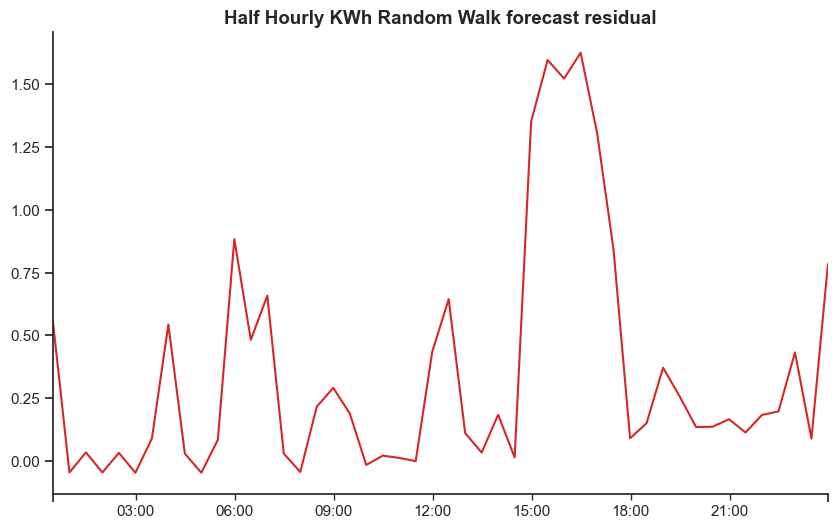

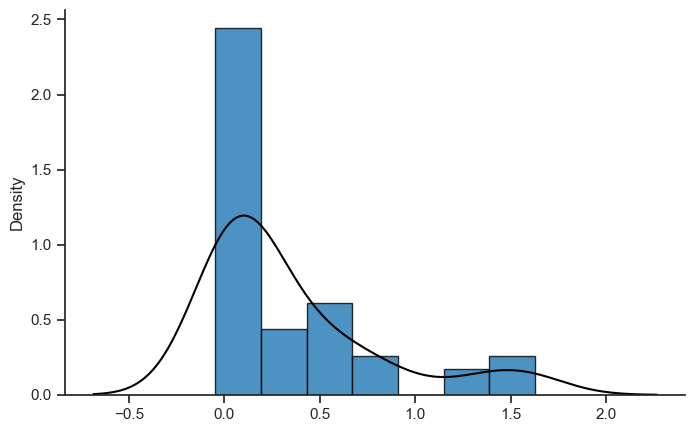

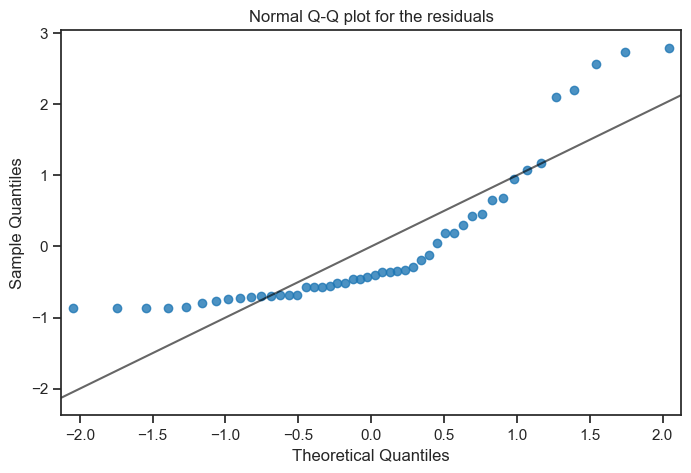

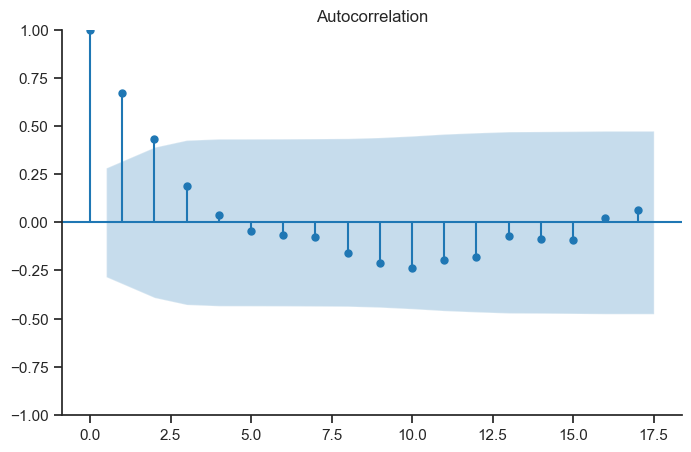

In [41]:
# model diagnostic: residual to detect bias for both model'
residual_half = halfhour_test_set - final_forecast_half_hourly

fig, ax = plt.subplots(figsize=(10,6))
residual_half.plot(color='#D62728', label='half_residual')
ax.set_xlabel('')
ax.set_title('Half Hourly KWh Random Walk forecast residual', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

# model diagnostic: histogram
forecast.histogram(residual_half)
plt.show()

# model diagnostic: qqplot
forecast.qq_plot(residual_half)
plt.show()

# model diagnostic: autocorrelation plot
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(residual_half, ax=ax)
sns.despine()
plt.show()

We base the diagnostic on the random walk model. The model seems to mostly capturing the time series patterns in the data, leading to small and insignicant residual correlation. However, there is significant residual correlation at lag 1 to 3, which is not the most ideal situation. One potential reason could be that the model is not able to capture the seasonality pattern in the data, which is evident from the ACF and PACF plot. 

Open-ended consideration/recommendation:

Given the time and resource constraint, the project does not include ways to leverage the predictive power of the half-hourly best model to predict monthly data. Nevertheless, future studies can be undertaken to integrate the strength of the half-hourly model by estalishing the baseline trend using the daily model, and uses the half-hourly model to capture short-term fluctuations.